# 0️⃣ General Background: Turbofan Engines 

![alt text](Turbofan-operation-lbp.png)

A turbofan engine is the dominant propulsion system for modern commercial and many military aircraft. It generates thrust by accelerating a large mass of air: the fan at the inlet produces most of the thrust by pushing air through a bypass duct, while the remaining air enters the core where it is compressed by the low-pressure compressor (LPC) and high-pressure compressor (HPC), mixed with fuel and combusted in the burner, and then expanded through the high-pressure turbine (HPT) and low-pressure turbine (LPT). The turbines extract energy to drive the compressors and fan through concentric shafts (spools). Because turbofan engines operate under varying loads and environmental conditions, their sensor readings can change due to both normal operating regime shifts and progressive component degradation, which makes Remaining Useful Life (RUL) prediction a realistic and high-value maintenance problem.

# 1️⃣ Data Acquisition: The C-MAPSS Dataset
For this project, the data is sourced from the NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) turbofan engine degradation dataset (commonly distributed via Kaggle). The dataset contains multivariate time-series measurements representing simulated engine operation from an initial healthy state through progressive degradation. Each record corresponds to one engine unit at a given cycle and includes operational settings and multiple sensor channels. The data is organized into four scenarios (FD001–FD004), where each scenario represents different levels of operating condition variability and fault complexity. For each scenario, there are three files: a training file (train_FD00x) containing full run-to-failure trajectories, a test file (test_FD00x) containing truncated trajectories ending before failure, and a corresponding RUL file (RUL_FD00x) providing the ground-truth remaining cycles for each test engine at its final observed cycle. In this work, the dataset is programmatically acquired directly from a GitHub repository (raw .txt files) into Python using pandas, ensuring a reproducible workflow that can be executed on any machine without manual file handling.

In [4]:
import numpy as np
import pandas as pd

BASE = "https://raw.githubusercontent.com/Tareq-Alsahaf/ISE-518/main/Data-CMaps"

SENSOR_NAMES = [
    "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)",
    "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)",
    "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)",
    "(Physical core speed) (rpm)",
    "(Engine pressure ratio (P50/P2))",
    "(HPC outlet Static pressure) (psia)",
    "(Ratio of fuel flow to Ps30) (pps/psia)",
    "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)",
    "(Bypass Ratio)",
    "(Burner fuel-air ratio)",
    "(Bleed Enthalpy)",
    "(Required fan speed)",
    "(Required fan conversion speed)",
    "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)",
]

def _make_cmaps_columns(n_cols: int):
    """
    C-MAPSS layout:
      2 id columns + 3 operational settings + N sensor columns (usually N=21)
    """
    if n_cols < 6:
        raise ValueError(f"Unexpected number of columns ({n_cols}). Expected at least 6.")
    n_sensors = n_cols - 5

    if n_sensors != len(SENSOR_NAMES):
        raise ValueError(
            f"Expected {len(SENSOR_NAMES)} sensors, but file has {n_sensors} sensor columns "
            f"(total columns={n_cols})."
        )

    cols = ["engine_id", "cycle", "op_setting_1", "op_setting_2", "op_setting_3"]
    cols += SENSOR_NAMES
    return cols

def _add_rul_train(train: pd.DataFrame) -> pd.DataFrame:
    """Train is run-to-failure => RUL = max(cycle per engine) - cycle."""
    df = train.copy()
    df["RUL"] = df.groupby("engine_id")["cycle"].transform("max") - df["cycle"]
    return df

def _add_rul_test(test: pd.DataFrame, rul_last_df: pd.DataFrame) -> pd.DataFrame:
    """
    Test does not run to failure.
    RUL file provides RUL at the LAST observed cycle for each engine.
    For each row: RUL = (last_cycle + RUL_last) - cycle
    """
    df = test.copy()

    # Align RUL rows to engine_id list in this test set (sorted)
    engine_ids = np.sort(df["engine_id"].unique())
    if len(engine_ids) != len(rul_last_df):
        raise ValueError(
            f"Mismatch: test has {len(engine_ids)} engines, but RUL file has {len(rul_last_df)} rows."
        )

    rul_map = pd.DataFrame({
        "engine_id": engine_ids,
        "RUL_last": rul_last_df["RUL"].to_numpy()
    })

    last_cycle = df.groupby("engine_id")["cycle"].max().reset_index(name="last_cycle")
    df = df.merge(last_cycle, on="engine_id", how="left").merge(rul_map, on="engine_id", how="left")

    df["RUL"] = (df["last_cycle"] + df["RUL_last"]) - df["cycle"]

    return df.drop(columns=["last_cycle", "RUL_last"])

def load_cmaps(fd: str):
    fd = fd.upper().replace(".TXT", "")
    if not fd.startswith("FD"):
        fd = f"FD{fd.zfill(3)}"  # e.g., "1" -> "FD001"

    train_url = f"{BASE}/Training/train_{fd}.txt"
    test_url  = f"{BASE}/Testing/test_{fd}.txt"
    rul_url   = f"{BASE}/Results%20(RUL)/RUL_{fd}.txt"

    train = pd.read_csv(train_url, sep=r"\s+", header=None).dropna(axis=1, how="all")
    test  = pd.read_csv(test_url,  sep=r"\s+", header=None).dropna(axis=1, how="all")
    rul   = pd.read_csv(rul_url,   sep=r"\s+", header=None).dropna(axis=1, how="all")

    train.columns = _make_cmaps_columns(train.shape[1])
    test.columns  = _make_cmaps_columns(test.shape[1])

    if rul.shape[1] != 1:
        raise ValueError(f"{fd} RUL file should have 1 column, but has {rul.shape[1]}.")
    rul.columns = ["RUL"]

    train["FD"] = fd
    test["FD"]  = fd
    rul["FD"]   = fd

    # Add RUL (NO CLIPPING)
    train = _add_rul_train(train)
    test  = _add_rul_test(test, rul)

    return train, test, rul

# Load all FD sets
FDs = ["FD001", "FD002", "FD003", "FD004"]
cmaps = {fd: dict(zip(["train", "test", "rul"], load_cmaps(fd))) for fd in FDs}

# Define variables: train_FD001..train_FD004, test_FD001..test_FD004, rul_FD001..rul_FD004
for fd in FDs:
    globals()[f"train_{fd}"] = cmaps[fd]["train"]
    globals()[f"test_{fd}"]  = cmaps[fd]["test"]
    globals()[f"rul_{fd}"]   = cmaps[fd]["rul"]

# Verify + preview
for fd in FDs:
    train = globals()[f"train_{fd}"]
    test  = globals()[f"test_{fd}"]
    rul   = globals()[f"rul_{fd}"]

    print(f"\n{fd} shapes -> train: {train.shape} | test: {test.shape} | rul: {rul.shape}")
    print(f"{fd} train RUL [min, max]: [{train['RUL'].min()} , {train['RUL'].max()}]")
    print(f"{fd} test  RUL [min, max]: [{test['RUL'].min()} , {test['RUL'].max()}]")

    display(train.head())
    display(test.head())
    display(rul.head())



FD001 shapes -> train: (20631, 28) | test: (13096, 28) | rul: (100, 2)
FD001 train RUL [min, max]: [0 , 361]
FD001 test  RUL [min, max]: [7 , 340]


engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       -0.0007       -0.0004         100.0   
1          1      2        0.0019       -0.0003         100.0   
2          1      3       -0.0043        0.0003         100.0   
3          1      4        0.0007        0.0000         100.0   
4          1      5       -0.0019       -0.0002         100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         641.82   
1                        518.67                         642.15   
2                        518.67                         642.35   
3                        518.67                         642.35   
4                        518.67                         642.37   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1589.70                        1400.60   
1                        1591.82                        1403.14   
2                        1587.99                        1404.20   
3                        1582.79                        1401.87   
4                        1582.85                        1406.22   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                        14.62  ...                       8138.62   
1                        14.62  ...                       8131.49   
2                        14.62  ...                       8133.23   
3                        14.62  ...                       8133.83   
4                        14.62  ...                       8133.80   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          8.4195                     0.03               392   
1          8.4318                     0.03               392   
2          8.4178                     0.03               390   
3          8.3682                     0.03               392   
4          8.4294                     0.03               393   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2388                            100.0   
1                  2388                            100.0   
2                  2388                            100.0   
3                  2388                            100.0   
4                  2388                            100.0   

   (High-pressure turbines Cool air flow)  \
0                                   39.06   
1                                   39.00   
2                                   38.95   
3                                   38.88   
4                                   38.90   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                23.4190  FD001  191  
1                                23.4236  FD001  190  
2                                23.3442  FD001  189  
3                                23.3739  FD001  188  
4                                23.4044  FD001  187  

[5 rows x 28 columns]

engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1        0.0023        0.0003         100.0   
1          1      2       -0.0027       -0.0003         100.0   
2          1      3        0.0003        0.0001         100.0   
3          1      4        0.0042        0.0000         100.0   
4          1      5        0.0014        0.0000         100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         643.02   
1                        518.67                         641.71   
2                        518.67                         642.46   
3                        518.67                         642.44   
4                        518.67                         642.51   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1585.29                        1398.21   
1                        1588.45                        1395.42   
2                        1586.94                        1401.34   
3                        1584.12                        1406.42   
4                        1587.19                        1401.92   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                        14.62  ...                       8125.55   
1                        14.62  ...                       8139.62   
2                        14.62  ...                       8130.10   
3                        14.62  ...                       8132.90   
4                        14.62  ...                       8129.54   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          8.4052                     0.03               392   
1          8.3803                     0.03               393   
2          8.4441                     0.03               393   
3          8.3917                     0.03               391   
4          8.4031                     0.03               390   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2388                            100.0   
1                  2388                            100.0   
2                  2388                            100.0   
3                  2388                            100.0   
4                  2388                            100.0   

   (High-pressure turbines Cool air flow)  \
0                                   38.86   
1                                   39.02   
2                                   39.08   
3                                   39.00   
4                                   38.99   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                23.3735  FD001  142  
1                                23.3916  FD001  141  
2                                23.4166  FD001  140  
3                                23.3737  FD001  139  
4                                23.4130  FD001  138  

[5 rows x 28 columns]

RUL     FD
0  112  FD001
1   98  FD001
2   69  FD001
3   82  FD001
4   91  FD001


FD002 shapes -> train: (53759, 28) | test: (33991, 28) | rul: (259, 2)
FD002 train RUL [min, max]: [0 , 377]
FD002 test  RUL [min, max]: [6 , 377]


engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       34.9983        0.8400         100.0   
1          1      2       41.9982        0.8408         100.0   
2          1      3       24.9988        0.6218          60.0   
3          1      4       42.0077        0.8416         100.0   
4          1      5       25.0005        0.6203          60.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        449.44                         555.32   
1                        445.00                         549.90   
2                        462.54                         537.31   
3                        445.00                         549.51   
4                        462.54                         537.07   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1358.61                        1137.23   
1                        1353.22                        1125.78   
2                        1256.76                        1047.45   
3                        1354.03                        1126.38   
4                        1257.71                        1047.93   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                         5.48  ...                       8048.56   
1                         3.91  ...                       8072.30   
2                         7.05  ...                       7864.87   
3                         3.91  ...                       8068.66   
4                         7.05  ...                       7861.23   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          9.3461                     0.02               334   
1          9.3774                     0.02               330   
2         10.8941                     0.02               309   
3          9.3528                     0.02               329   
4         10.8963                     0.02               309   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2223                           100.00   
1                  2212                           100.00   
2                  1915                            84.93   
3                  2212                           100.00   
4                  1915                            84.93   

   (High-pressure turbines Cool air flow)  \
0                                   14.73   
1                                   10.41   
2                                   14.08   
3                                   10.59   
4                                   14.13   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                 8.8071  FD002  148  
1                                 6.2665  FD002  147  
2                                 8.6723  FD002  146  
3                                 6.4701  FD002  145  
4                                 8.5286  FD002  144  

[5 rows x 28 columns]

engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1        9.9987        0.2502         100.0   
1          1      2       20.0026        0.7000         100.0   
2          1      3       35.0045        0.8400         100.0   
3          1      4       42.0066        0.8410         100.0   
4          1      5       24.9985        0.6213          60.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        489.05                         605.03   
1                        491.19                         607.82   
2                        449.44                         556.00   
3                        445.00                         550.17   
4                        462.54                         536.72   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1497.17                        1304.99   
1                        1481.20                        1246.11   
2                        1359.08                        1128.36   
3                        1349.69                        1127.89   
4                        1253.18                        1050.69   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                        10.52  ...                       8114.10   
1                         9.35  ...                       8053.06   
2                         5.48  ...                       8053.04   
3                         3.91  ...                       8066.90   
4                         7.05  ...                       7865.66   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          8.6476                     0.03               369   
1          9.2405                     0.02               364   
2          9.3472                     0.02               333   
3          9.3961                     0.02               332   
4         10.8682                     0.02               305   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2319                           100.00   
1                  2324                           100.00   
2                  2223                           100.00   
3                  2212                           100.00   
4                  1915                            84.93   

   (High-pressure turbines Cool air flow)  \
0                                   28.42   
1                                   24.29   
2                                   14.98   
3                                   10.35   
4                                   14.31   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                17.1551  FD002  275  
1                                14.8039  FD002  274  
2                                 8.9125  FD002  273  
3                                 6.4181  FD002  272  
4                                 8.5740  FD002  271  

[5 rows x 28 columns]

RUL     FD
0   18  FD002
1   79  FD002
2  106  FD002
3  110  FD002
4   15  FD002


FD003 shapes -> train: (24720, 28) | test: (16596, 28) | rul: (100, 2)
FD003 train RUL [min, max]: [0 , 524]
FD003 test  RUL [min, max]: [6 , 483]


engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       -0.0005        0.0004         100.0   
1          1      2        0.0008       -0.0003         100.0   
2          1      3       -0.0014       -0.0002         100.0   
3          1      4       -0.0020        0.0001         100.0   
4          1      5        0.0016        0.0000         100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         642.36   
1                        518.67                         642.50   
2                        518.67                         642.18   
3                        518.67                         642.92   
4                        518.67                         641.68   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1583.23                        1396.84   
1                        1584.69                        1396.89   
2                        1582.35                        1405.61   
3                        1585.61                        1392.27   
4                        1588.63                        1397.65   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                        14.62  ...                       8145.32   
1                        14.62  ...                       8152.85   
2                        14.62  ...                       8150.17   
3                        14.62  ...                       8146.56   
4                        14.62  ...                       8147.80   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          8.4246                     0.03               391   
1          8.4403                     0.03               392   
2          8.3901                     0.03               391   
3          8.3878                     0.03               392   
4          8.3869                     0.03               392   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2388                            100.0   
1                  2388                            100.0   
2                  2388                            100.0   
3                  2388                            100.0   
4                  2388                            100.0   

   (High-pressure turbines Cool air flow)  \
0                                   39.11   
1                                   38.99   
2                                   38.85   
3                                   38.96   
4                                   39.14   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                23.3537  FD003  258  
1                                23.4491  FD003  257  
2                                23.3669  FD003  256  
3                                23.2951  FD003  255  
4                                23.4583  FD003  254  

[5 rows x 28 columns]

engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       -0.0017       -0.0004         100.0   
1          1      2        0.0006       -0.0002         100.0   
2          1      3        0.0014       -0.0003         100.0   
3          1      4        0.0027        0.0001         100.0   
4          1      5       -0.0001        0.0001         100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         641.94   
1                        518.67                         642.02   
2                        518.67                         641.68   
3                        518.67                         642.20   
4                        518.67                         642.46   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1581.93                        1396.93   
1                        1584.86                        1398.90   
2                        1581.78                        1391.92   
3                        1584.53                        1395.34   
4                        1589.03                        1395.86   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                        14.62  ...                       8133.48   
1                        14.62  ...                       8137.44   
2                        14.62  ...                       8138.25   
3                        14.62  ...                       8137.07   
4                        14.62  ...                       8134.20   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          8.3760                     0.03               391   
1          8.4062                     0.03               391   
2          8.3553                     0.03               391   
3          8.3709                     0.03               392   
4          8.4146                     0.03               391   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2388                            100.0   
1                  2388                            100.0   
2                  2388                            100.0   
3                  2388                            100.0   
4                  2388                            100.0   

   (High-pressure turbines Cool air flow)  \
0                                   39.07   
1                                   39.04   
2                                   39.10   
3                                   38.97   
4                                   39.09   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                23.4468  FD003  276  
1                                23.4807  FD003  275  
2                                23.4244  FD003  274  
3                                23.4782  FD003  273  
4                                23.3950  FD003  272  

[5 rows x 28 columns]

RUL     FD
0   44  FD003
1   51  FD003
2   27  FD003
3  120  FD003
4  101  FD003


FD004 shapes -> train: (61249, 28) | test: (41214, 28) | rul: (248, 2)
FD004 train RUL [min, max]: [0 , 542]
FD004 test  RUL [min, max]: [6 , 553]


engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       42.0049        0.8400         100.0   
1          1      2       20.0020        0.7002         100.0   
2          1      3       42.0038        0.8409         100.0   
3          1      4       42.0000        0.8400         100.0   
4          1      5       25.0063        0.6207          60.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        445.00                         549.68   
1                        491.19                         606.07   
2                        445.00                         548.95   
3                        445.00                         548.70   
4                        462.54                         536.10   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1343.43                        1112.93   
1                        1477.61                        1237.50   
2                        1343.12                        1117.05   
3                        1341.24                        1118.03   
4                        1255.23                        1033.59   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                         3.91  ...                       8074.83   
1                         9.35  ...                       8046.13   
2                         3.91  ...                       8066.62   
3                         3.91  ...                       8076.05   
4                         7.05  ...                       7865.80   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          9.3335                     0.02               330   
1          9.1913                     0.02               361   
2          9.4007                     0.02               329   
3          9.3369                     0.02               328   
4         10.8366                     0.02               305   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2212                           100.00   
1                  2324                           100.00   
2                  2212                           100.00   
3                  2212                           100.00   
4                  1915                            84.93   

   (High-pressure turbines Cool air flow)  \
0                                   10.62   
1                                   24.37   
2                                   10.48   
3                                   10.54   
4                                   14.03   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                 6.3670  FD004  320  
1                                14.6552  FD004  319  
2                                 6.4213  FD004  318  
3                                 6.4176  FD004  317  
4                                 8.6754  FD004  316  

[5 rows x 28 columns]

engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  \
0          1      1       20.0072        0.7000         100.0   
1          1      2       24.9984        0.6200          60.0   
2          1      3       42.0000        0.8420         100.0   
3          1      4       42.0035        0.8402         100.0   
4          1      5       35.0079        0.8400         100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        491.19                         606.67   
1                        462.54                         536.22   
2                        445.00                         549.23   
3                        445.00                         549.19   
4                        449.44                         555.10   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1481.04                        1227.81   
1                        1256.17                        1031.48   
2                        1340.13                        1105.88   
3                        1339.70                        1107.26   
4                        1353.04                        1117.80   

   (Fan inlet Pressure) (psia)  ...  (Corrected core speed) (rpm)  \
0                         9.35  ...                       8048.98   
1                         7.05  ...                       7863.46   
2                         3.91  ...                       8071.13   
3                         3.91  ...                       8078.89   
4                         5.48  ...                       8057.83   

   (Bypass Ratio)  (Burner fuel-air ratio)  (Bleed Enthalpy)  \
0          9.2229                     0.02               362   
1         10.8632                     0.02               306   
2          9.3960                     0.02               328   
3          9.3594                     0.02               328   
4          9.3030                     0.02               333   

   (Required fan speed)  (Required fan conversion speed)  \
0                  2324                           100.00   
1                  1915                            84.93   
2                  2212                           100.00   
3                  2212                           100.00   
4                  2223                           100.00   

   (High-pressure turbines Cool air flow)  \
0                                   24.31   
1                                   14.36   
2                                   10.39   
3                                   10.56   
4                                   14.85   

   (Low-pressure turbines Cool air flow)     FD  RUL  
0                                14.7007  FD004  251  
1                                 8.5748  FD004  250  
2                                 6.4365  FD004  249  
3                                 6.2367  FD004  248  
4                                 8.9326  FD004  247  

[5 rows x 28 columns]

RUL     FD
0   22  FD004
1   39  FD004
2  107  FD004
3   75  FD004
4  149  FD004

# 2️⃣ Data Quality Checks: Missing Values & Duplicate Rows

- Loaded the four C-MAPSS scenarios (**FD001–FD004**) in three components per scenario: **TRAIN**, **TEST**, and **RUL**.
- For each dataset component (e.g., `FD001-TRAIN`, `FD001-TEST`, `FD001-RUL`), computed the **total number of missing/empty values** across all cells.
- For each dataset component, computed the **number of duplicated rows** (exact row duplicates across all columns).
- Compiled the results into a single summary table to quickly verify data integrity before proceeding to deeper cleaning steps (e.g., normalization, outlier screening, and feature analysis).


In [3]:
import pandas as pd

FDs = ["FD001", "FD002", "FD003", "FD004"]

rows = []
for fd in FDs:
    for part in ["train", "test", "rul"]:
        df = cmaps[fd][part]
        missing = int(df.isna().sum().sum())
        duplicates = int(df.duplicated().sum())
        rows.append([f"{fd}-{part.upper()}", missing, duplicates])

report = pd.DataFrame(rows, columns=["Dataset", "Missing_Values", "Duplicate_Rows"])
display(report)


Dataset  Missing_Values  Duplicate_Rows
0   FD001-TRAIN               0               0
1    FD001-TEST               0               0
2     FD001-RUL               0              29
3   FD002-TRAIN               0               0
4    FD002-TEST               0               0
5     FD002-RUL               0             127
6   FD003-TRAIN               0               0
7    FD003-TEST               0               0
8     FD003-RUL               0              31
9   FD004-TRAIN               0               0
10   FD004-TEST               0               0
11    FD004-RUL               0             117

# 3️⃣ Data Cleaning: Extreme Outliers (Reporting Only)

- Performed **extreme outlier detection** for **all C-MAPSS scenarios (FD001–FD004)** on **sensor channels only**.
- Used a **conservative IQR-based rule (3×IQR)** to define extreme outlier thresholds:
  - Lower bound = Q1 − 3×IQR  
  - Upper bound = Q3 + 3×IQR
- Estimated outlier bounds from the **TRAIN split only** (per FD set) and used those bounds to **flag** extreme values in both **TRAIN and TEST** splits.
- Generated a summary table reporting, for each dataset component (`FD00x-TRAIN` and `FD00x-TEST`):
  - the total number of **flagged extreme sensor cells**, and
  - the number/proportion of **rows (cycles) containing ≥1 flagged sensor value**.
- **No values were removed or modified** (no clipping, no row deletion). Outliers were **reported for transparency** while preserving realistic operating variability and degradation behavior for subsequent modeling.


In [4]:
import numpy as np
import pandas as pd

FDs = ["FD001", "FD002", "FD003", "FD004"]

def get_sensor_cols(df: pd.DataFrame):
    return [c for c in df.columns if isinstance(c, str) and c.strip().startswith("(")]

def iqr_outlier_report(train_df: pd.DataFrame, target_df: pd.DataFrame, sensor_cols, k=3.0):
    """
    Fit bounds on TRAIN only, then flag outliers in target_df.
    Extreme IQR bounds: Q1 - k*IQR, Q3 + k*IQR  (k=3 is conservative)
    Returns: (#outlier_cells, #rows_with_any_outlier, top_sensors_series)
    """
    q1 = train_df[sensor_cols].quantile(0.25)
    q3 = train_df[sensor_cols].quantile(0.75)
    iqr = (q3 - q1).replace(0, np.nan)
    lower = q1 - k * iqr
    upper = q3 + k * iqr

    mask = target_df[sensor_cols].lt(lower, axis=1) | target_df[sensor_cols].gt(upper, axis=1)
    outlier_cells = int(mask.sum().sum())
    outlier_rows = int(mask.any(axis=1).sum())
    top_sensors = mask.sum().sort_values(ascending=False)
    return outlier_cells, outlier_rows, top_sensors

rows = []
top_sensors_by_dataset = {}

for fd in FDs:
    train = cmaps[fd]["train"]
    test  = cmaps[fd]["test"]

    sensor_cols = get_sensor_cols(train)
    if not sensor_cols:
        raise ValueError(f"{fd}: No sensor columns detected (expected columns starting with '(').")

    tr_cells, tr_rows, tr_top = iqr_outlier_report(train, train, sensor_cols, k=3.0)
    te_cells, te_rows, te_top = iqr_outlier_report(train, test,  sensor_cols, k=3.0)

    rows.append([f"{fd}-TRAIN", tr_cells, tr_rows, tr_rows/len(train)])
    rows.append([f"{fd}-TEST",  te_cells, te_rows, te_rows/len(test)])

    top_sensors_by_dataset[f"{fd}-TRAIN"] = tr_top.head(10)
    top_sensors_by_dataset[f"{fd}-TEST"]  = te_top.head(10)

outlier_summary = pd.DataFrame(
    rows,
    columns=["Dataset", "Flagged_Outlier_Cells", "Rows_With_>=1_Flag", "Ratio_Rows_Flagged"]
)

outlier_summary["Pct_Rows_Flagged_%"] = (outlier_summary["Ratio_Rows_Flagged"] * 100).round(2)


display(outlier_summary)



Dataset  Flagged_Outlier_Cells  Rows_With_>=1_Flag  Ratio_Rows_Flagged  \
0  FD001-TRAIN                   1505                 819            0.039698   
1   FD001-TEST                     75                  43            0.003283   
2  FD002-TRAIN                   9417                8550            0.159043   
3   FD002-TEST                   5682                5085            0.149598   
4  FD003-TRAIN                   3624                1813            0.073341   
5   FD003-TEST                   1297                 687            0.041396   
6  FD004-TRAIN                  10176                9445            0.154207   
7   FD004-TEST                   6738                6131            0.148760   

   Pct_Rows_Flagged_%  
0                3.97  
1                0.33  
2               15.90  
3               14.96  
4                7.33  
5                4.14  
6               15.42  
7               14.88

# 5️⃣ Univariate Analysis: Sensor Distributions by FD Set (Overlay Histograms)

- Generated **univariate histograms** for **each sensor channel** using the **raw (non-normalized) values**.
- For every sensor, plotted **four overlaid histograms** corresponding to **FD001, FD002, FD003, and FD004** (TRAIN + TEST pooled within each FD set), using **different colors** to visually compare distributions across scenarios.
- Used a **common set of bin edges per sensor** across all FD sets to ensure a **fair, consistent comparison** of histogram shapes.
- Added a **dashed vertical line** for each FD set showing the **mean (expected value)** of that sensor under that scenario.
- Interpreted multi-peak (multi-modal) shapes as evidence of **mixed operating regimes and scenario differences**, rather than immediate data quality issues.


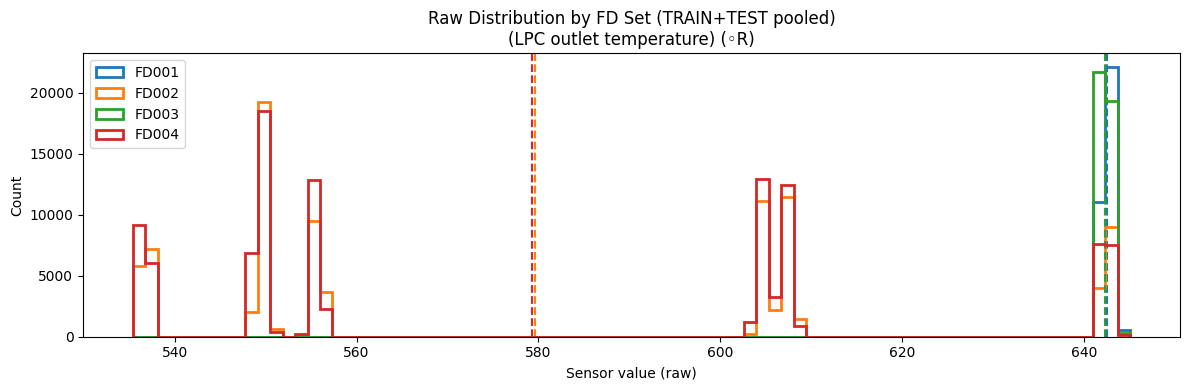

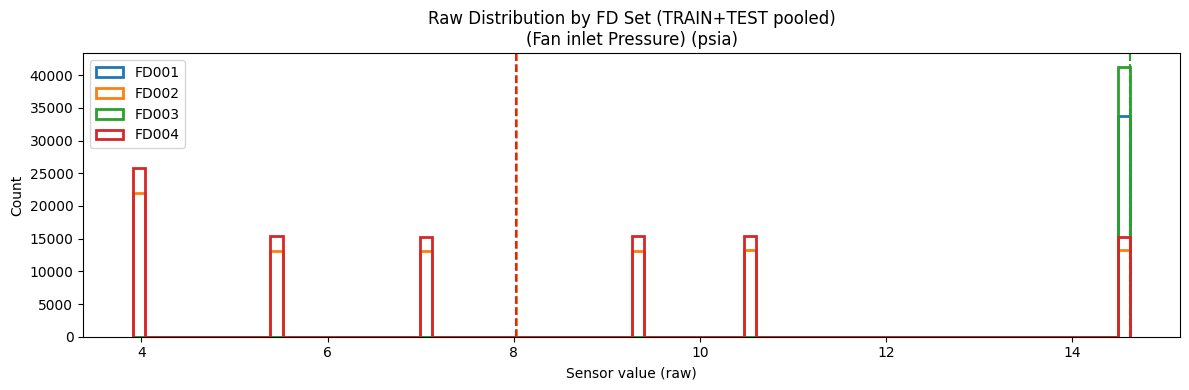

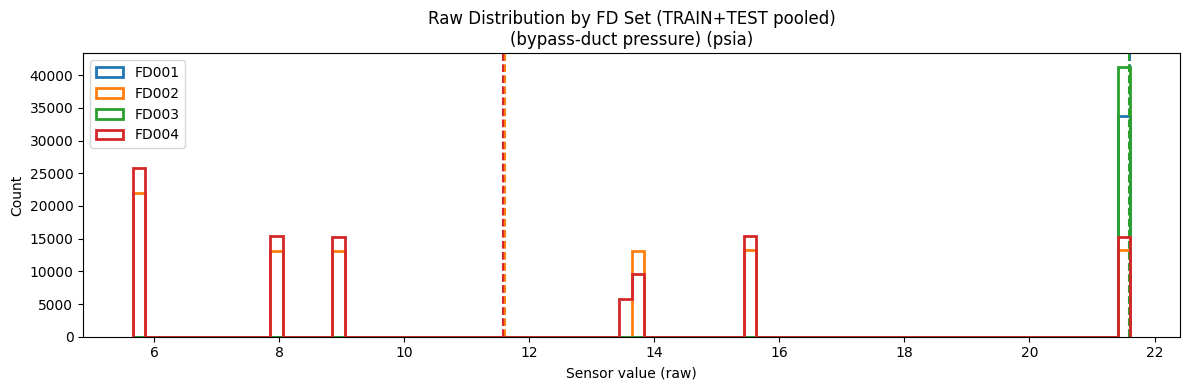

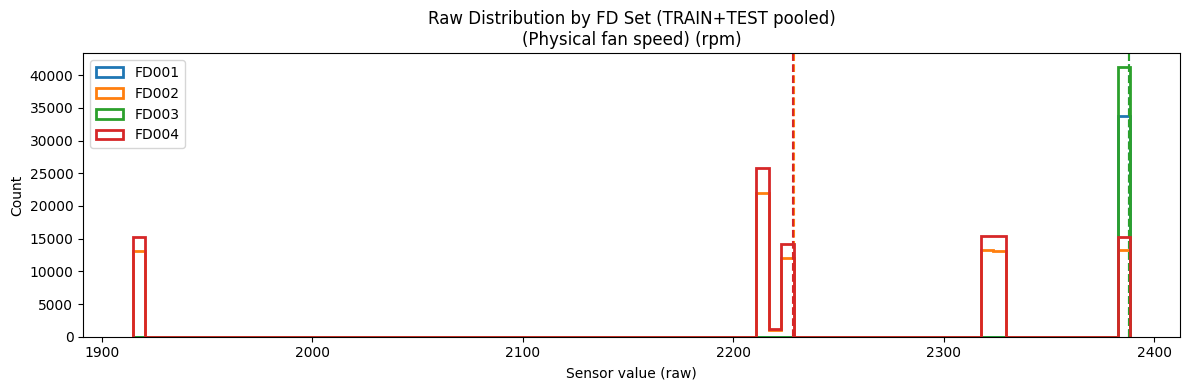

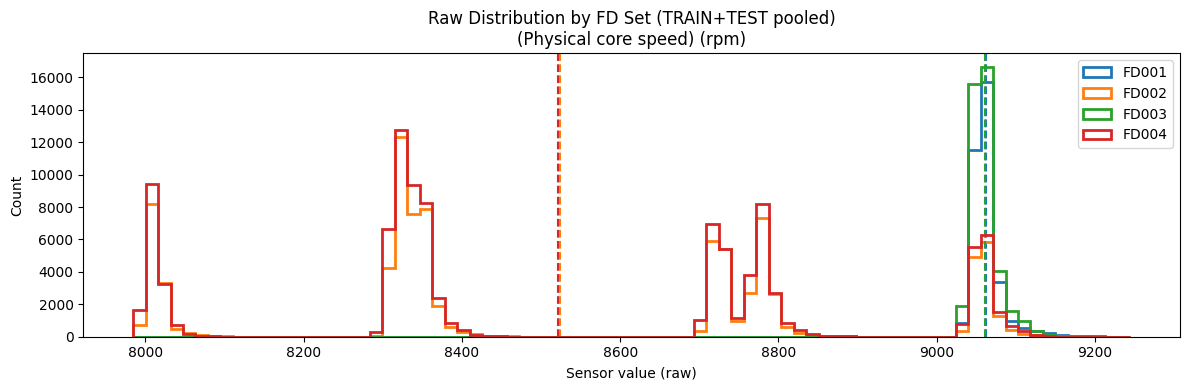

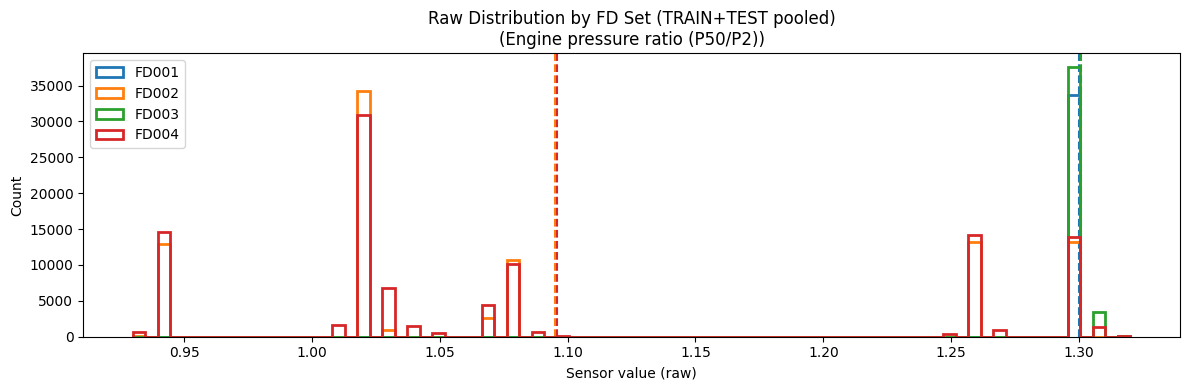

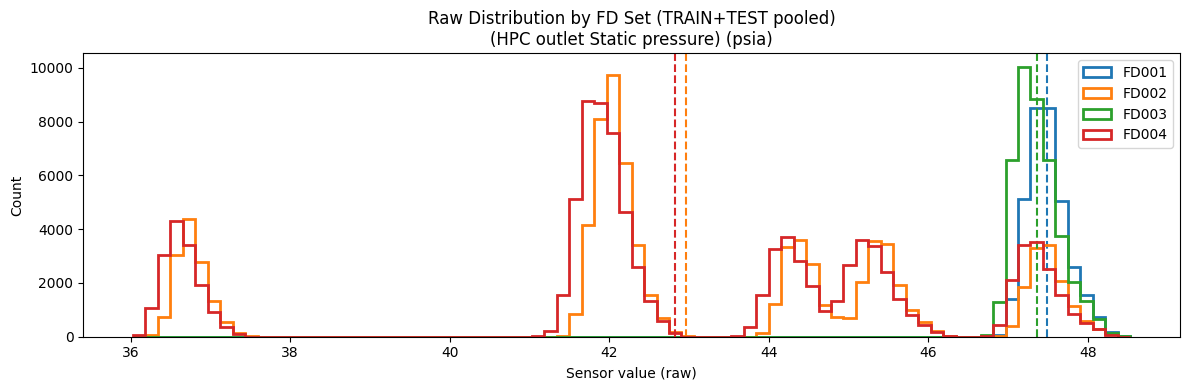

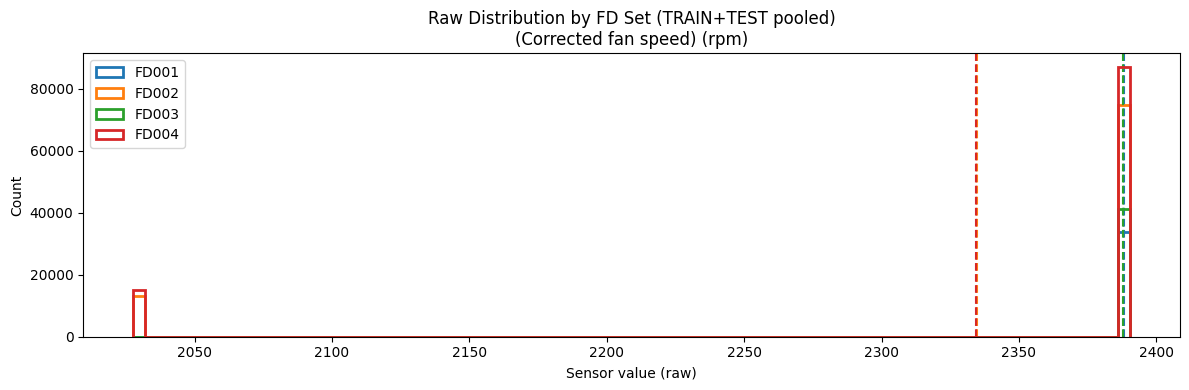

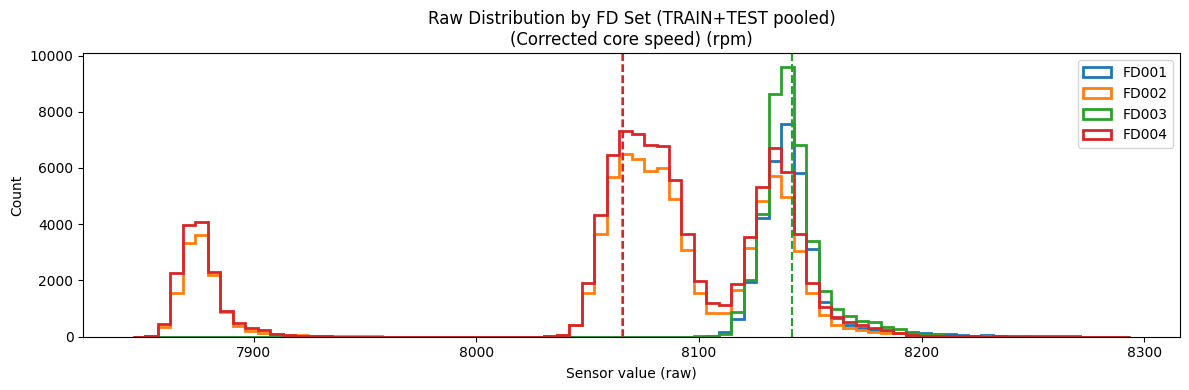

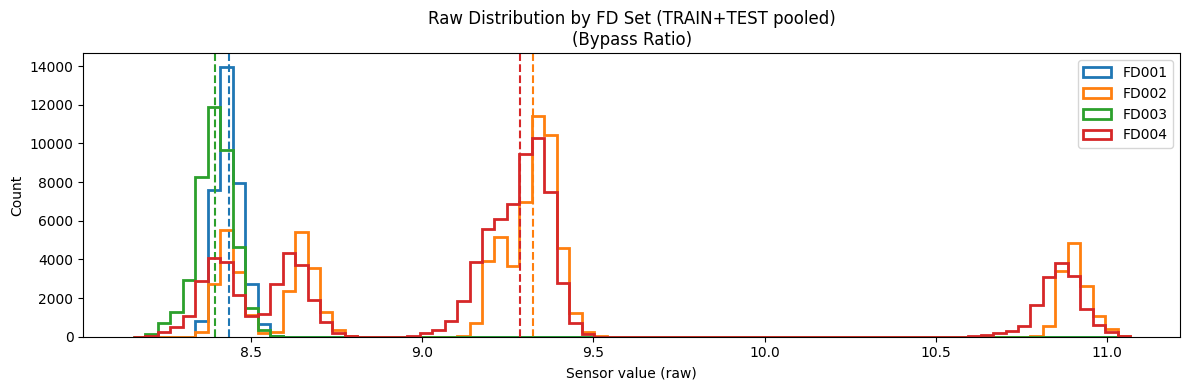

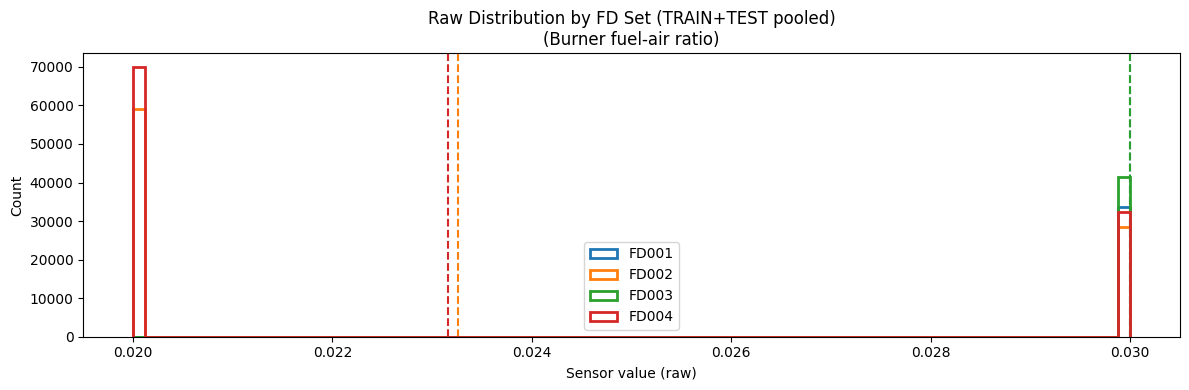

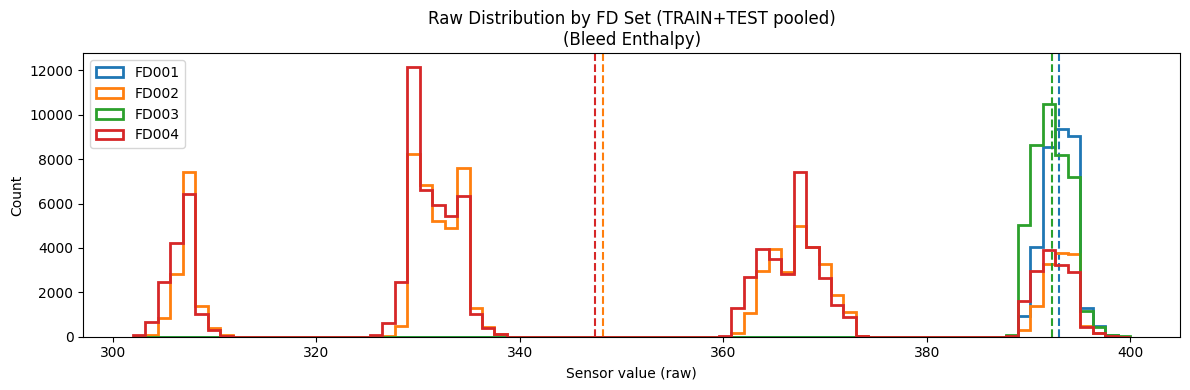

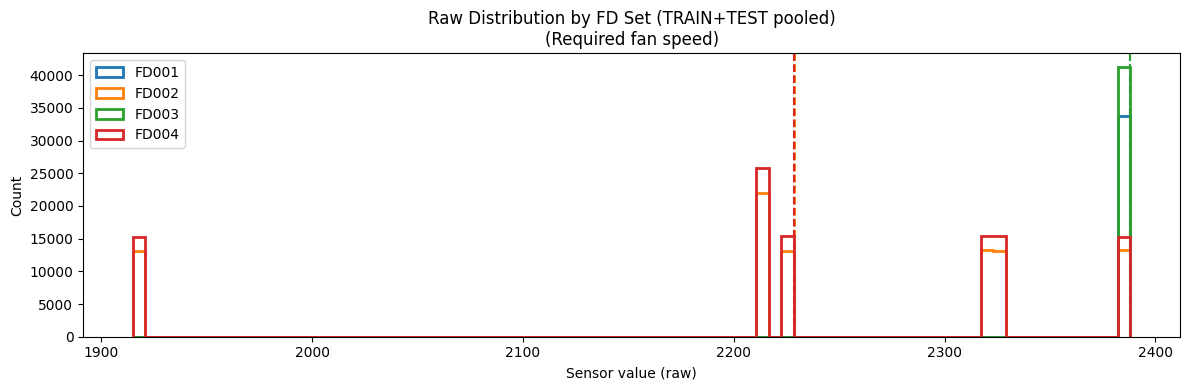

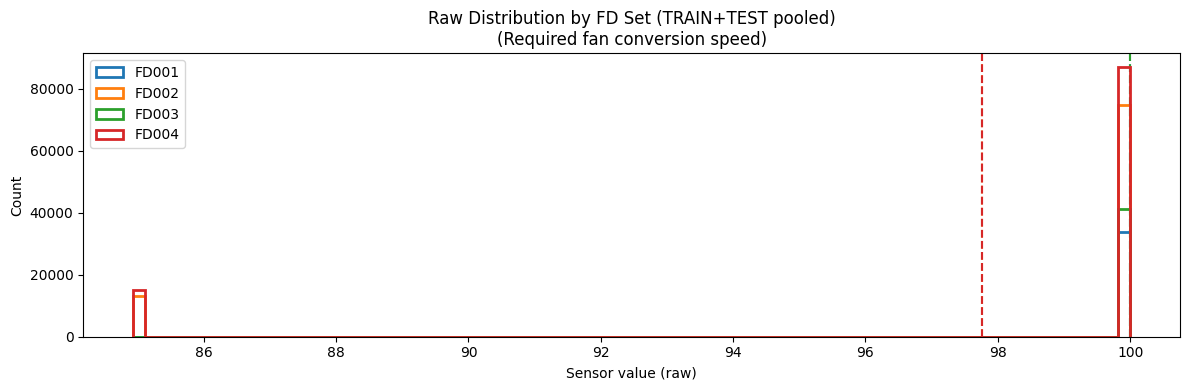

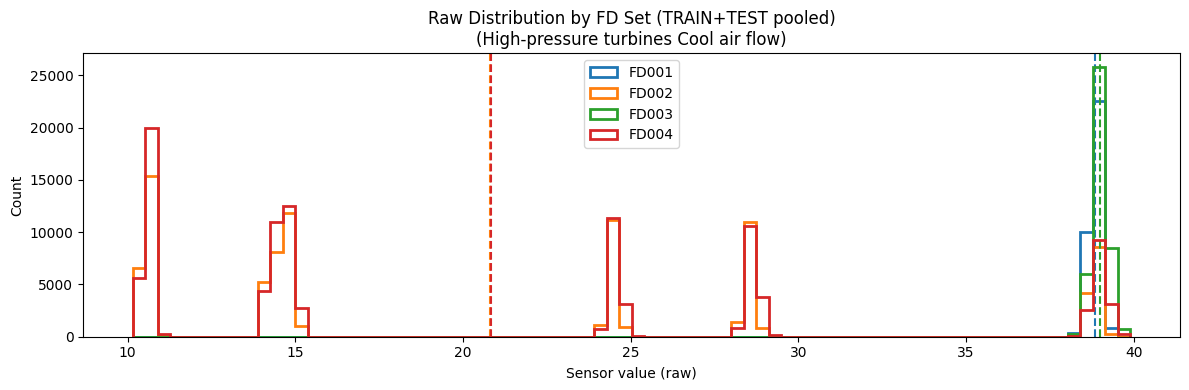

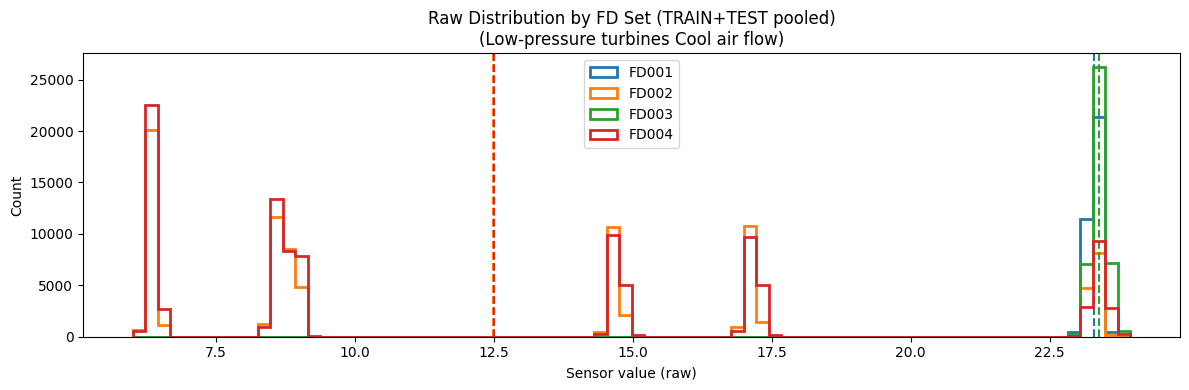

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

FDs = ["FD001", "FD002", "FD003", "FD004"]

# Detect sensor columns (your labeled sensors start with "(" )
sensor_cols = [c for c in cmaps["FD001"]["train"].columns
               if isinstance(c, str) and c.strip().startswith("(")]
if not sensor_cols:
    raise ValueError("No sensor columns detected (expected columns starting with '(').")

# Pool raw data per FD (TRAIN + TEST)
pooled_by_fd = {}
for fd in FDs:
    pooled_by_fd[fd] = pd.concat(
        [cmaps[fd]["train"][sensor_cols], cmaps[fd]["test"][sensor_cols]],
        ignore_index=True
    )

BINS = 80  # adjust if you want smoother/rougher histograms

# One plot per sensor (this will generate 21 figures)
for s in sensor_cols:
    # Common bin edges across FD001–FD004 for this sensor (ensures fair visual comparison)
    all_vals = np.concatenate([
        pooled_by_fd[fd][s].dropna().to_numpy() for fd in FDs
    ])
    bin_edges = np.histogram_bin_edges(all_vals, bins=BINS)

    plt.figure(figsize=(12, 4))

    for fd in FDs:
        vals = pooled_by_fd[fd][s].dropna().to_numpy()
        mu = float(np.mean(vals))

        # Histogram (different color per FD using default matplotlib cycle)
        n, bins, patches = plt.hist(
            vals, bins=bin_edges, histtype="step", linewidth=2, label=fd
        )

        # Use the same color as the histogram outline for the mean line
        try:
            c = patches[0].get_edgecolor()
        except Exception:
            c = None

        plt.axvline(mu, linestyle="--", linewidth=1.5, color=c)

    plt.title(f"Raw Distribution by FD Set (TRAIN+TEST pooled)\n{s}")
    plt.xlabel("Sensor value (raw)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 6️⃣ Multivariate Analysis: Correlation Heatmaps per FD Set (Sensors + RUL)

- Generated **separate correlation heatmaps** for each scenario (**FD001–FD004**) to avoid mixing different operating conditions and fault complexities in a single pooled matrix.
- Used **TRAIN data only** for each FD set to ensure consistent analysis and to enable computation of cycle-level **RUL** from run-to-failure trajectories.
- Computed **RUL for every training row** using: `RUL = max_cycle(engine) − cycle`, then included **RUL** alongside the **21 sensor channels** in the correlation matrix.
- Visualized correlations using a **red–blue colormap** with a fixed range **[-1, 1]**, where:
  - **Red** indicates strong positive correlation,
  - **Blue** indicates strong negative correlation,
  - and light/neutral colors indicate weak linear relationships.
- Observed that correlation patterns are **scenario-dependent**:
  - some FD sets exhibit stronger sensor redundancy (high multicollinearity),
  - while others show clearer structured relationships.
- Noted that sensors with near-constant behavior appear as weak/undefined correlation bands, indicating potential **low-informative features** for modeling.
- Interpreted the **sensor–RUL** correlations as a global linear summary; weak Pearson correlation does not imply low usefulness, since degradation information is often captured through **time-dependent trends** rather than instantaneous sensor values.



Axis label map (Sxx -> sensor name):
S01: (Fan inlet temperature) (◦R)
S02: (LPC outlet temperature) (◦R)
S03: (HPC outlet temperature) (◦R)
S04: (LPT outlet temperature) (◦R)
S05: (Fan inlet Pressure) (psia)
S06: (bypass-duct pressure) (psia)
S07: (HPC outlet pressure) (psia)
S08: (Physical fan speed) (rpm)
S09: (Physical core speed) (rpm)
S10: (Engine pressure ratio (P50/P2))
S11: (HPC outlet Static pressure) (psia)
S12: (Ratio of fuel flow to Ps30) (pps/psia)
S13: (Corrected fan speed) (rpm)
S14: (Corrected core speed) (rpm)
S15: (Bypass Ratio)
S16: (Burner fuel-air ratio)
S17: (Bleed Enthalpy)
S18: (Required fan speed)
S19: (Required fan conversion speed)
S20: (High-pressure turbines Cool air flow)
S21: (Low-pressure turbines Cool air flow)
RUL: Remaining Useful Life (cycles) computed from TRAIN (run-to-failure)


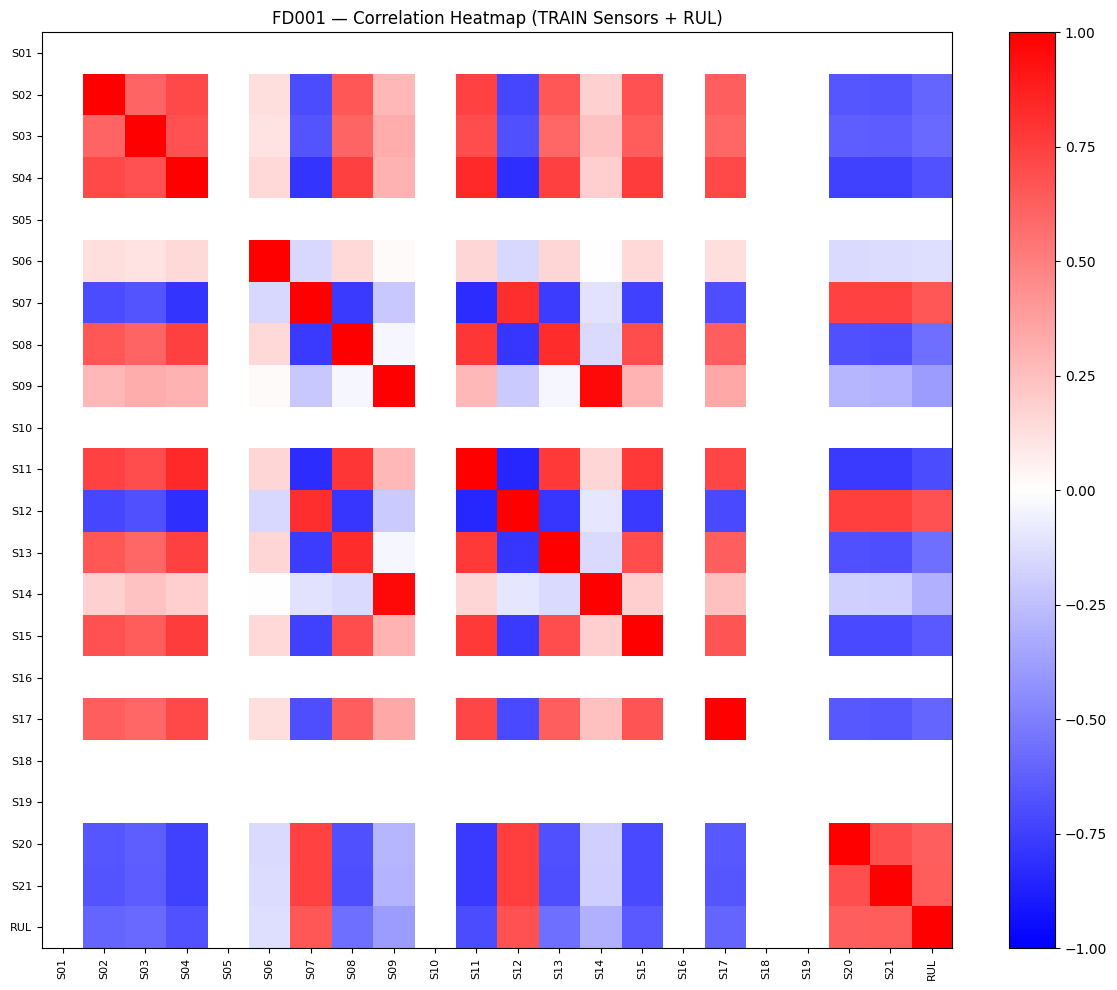


FD001 — Top 10 sensors by |corr with RUL|:


corr_with_RUL
(HPC outlet Static pressure) (psia)          -0.696228
(LPT outlet temperature) (◦R)                -0.678948
(Ratio of fuel flow to Ps30) (pps/psia)       0.671983
(HPC outlet pressure) (psia)                  0.657223
(Bypass Ratio)                               -0.642667
(Low-pressure turbines Cool air flow)         0.635662
(High-pressure turbines Cool air flow)        0.629428
(LPC outlet temperature) (◦R)                -0.606484
(Bleed Enthalpy)                             -0.606154
(HPC outlet temperature) (◦R)                -0.584520

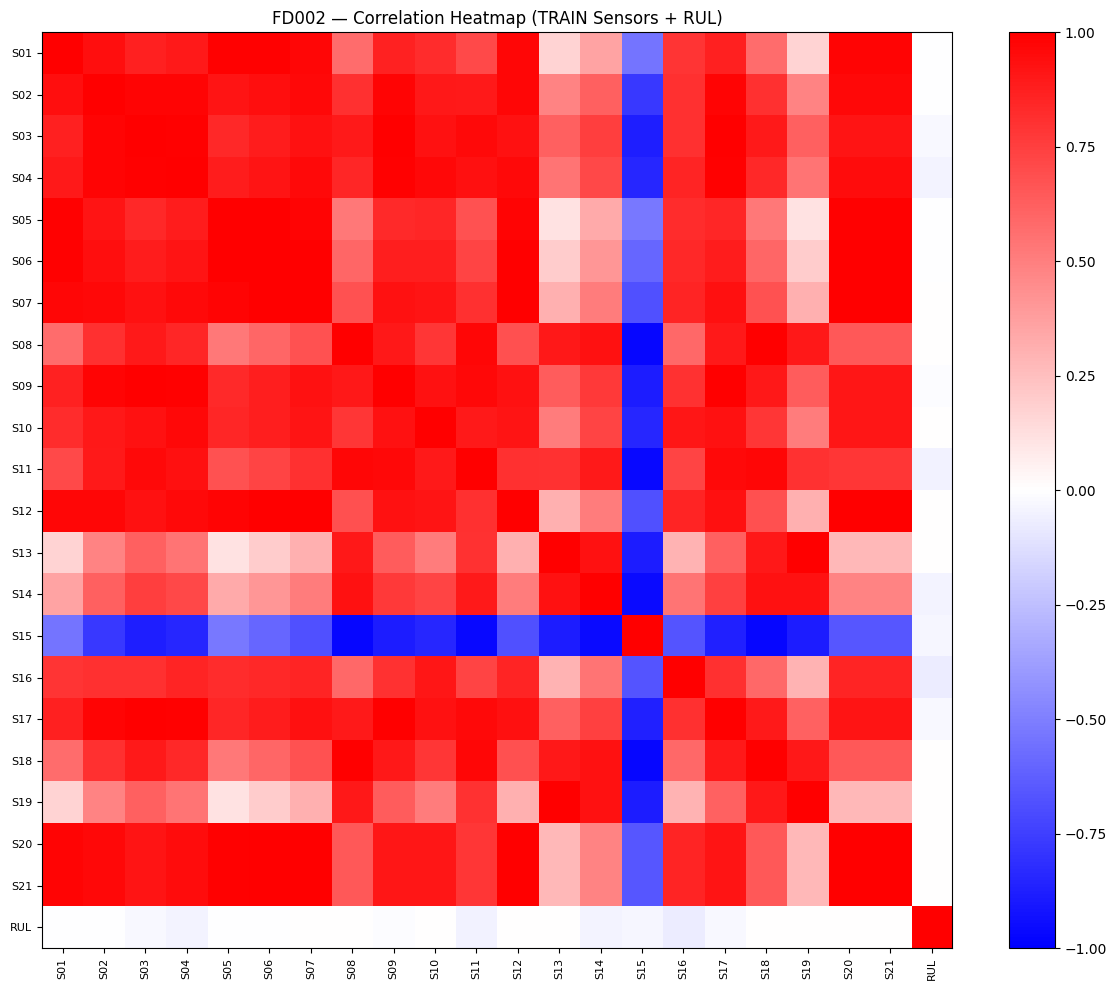


FD002 — Top 10 sensors by |corr with RUL|:


corr_with_RUL
(Burner fuel-air ratio)                     -0.071352
(HPC outlet Static pressure) (psia)         -0.046950
(Corrected core speed) (rpm)                -0.042325
(LPT outlet temperature) (◦R)               -0.040978
(Bypass Ratio)                              -0.038455
(Bleed Enthalpy)                            -0.027031
(HPC outlet temperature) (◦R)               -0.026942
(Physical core speed) (rpm)                 -0.015306
(High-pressure turbines Cool air flow)       0.006287
(Low-pressure turbines Cool air flow)        0.006165

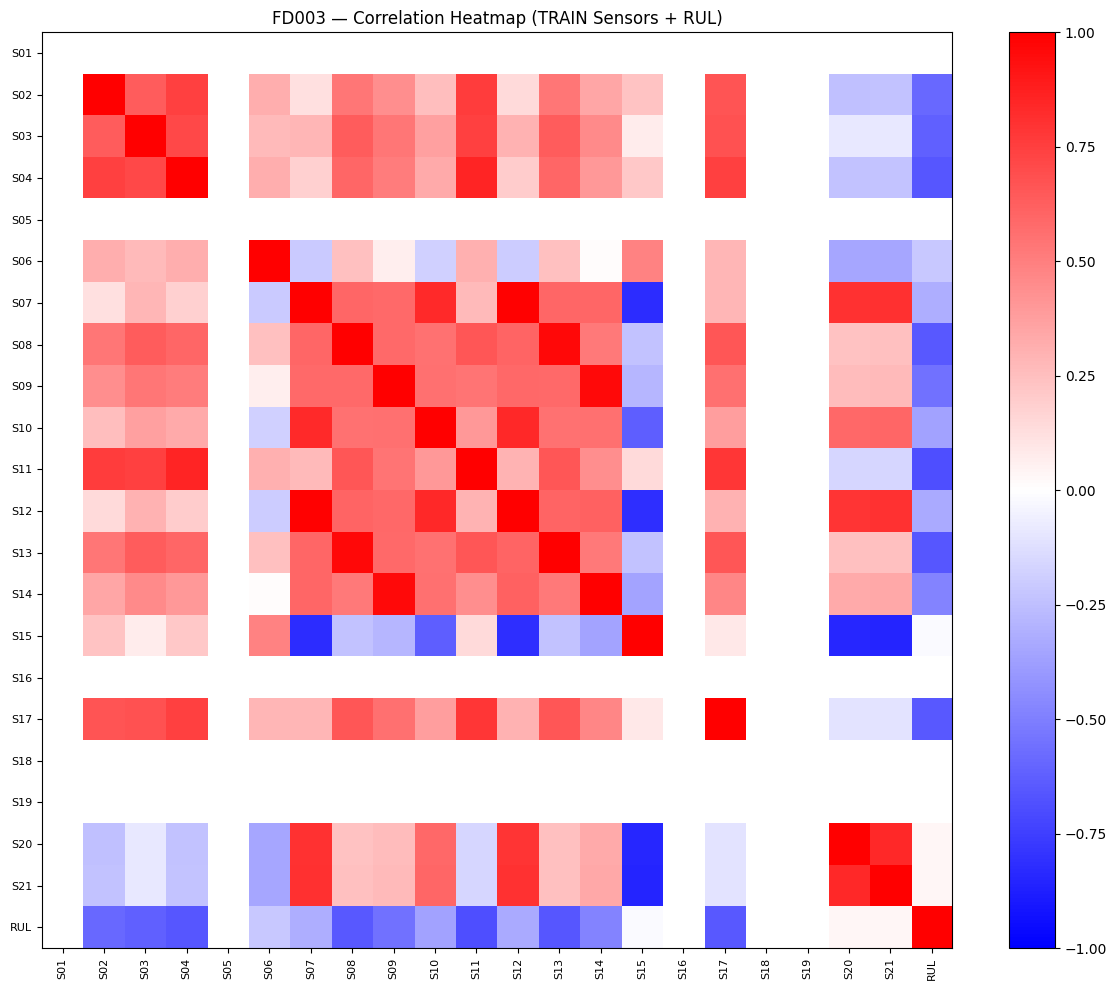


FD003 — Top 10 sensors by |corr with RUL|:


corr_with_RUL
(HPC outlet Static pressure) (psia)      -0.688915
(LPT outlet temperature) (◦R)            -0.657224
(Corrected fan speed) (rpm)              -0.656340
(Physical fan speed) (rpm)               -0.655345
(Bleed Enthalpy)                         -0.649220
(HPC outlet temperature) (◦R)            -0.624236
(LPC outlet temperature) (◦R)            -0.590564
(Physical core speed) (rpm)              -0.551843
(Corrected core speed) (rpm)             -0.481807
(Engine pressure ratio (P50/P2))         -0.363432

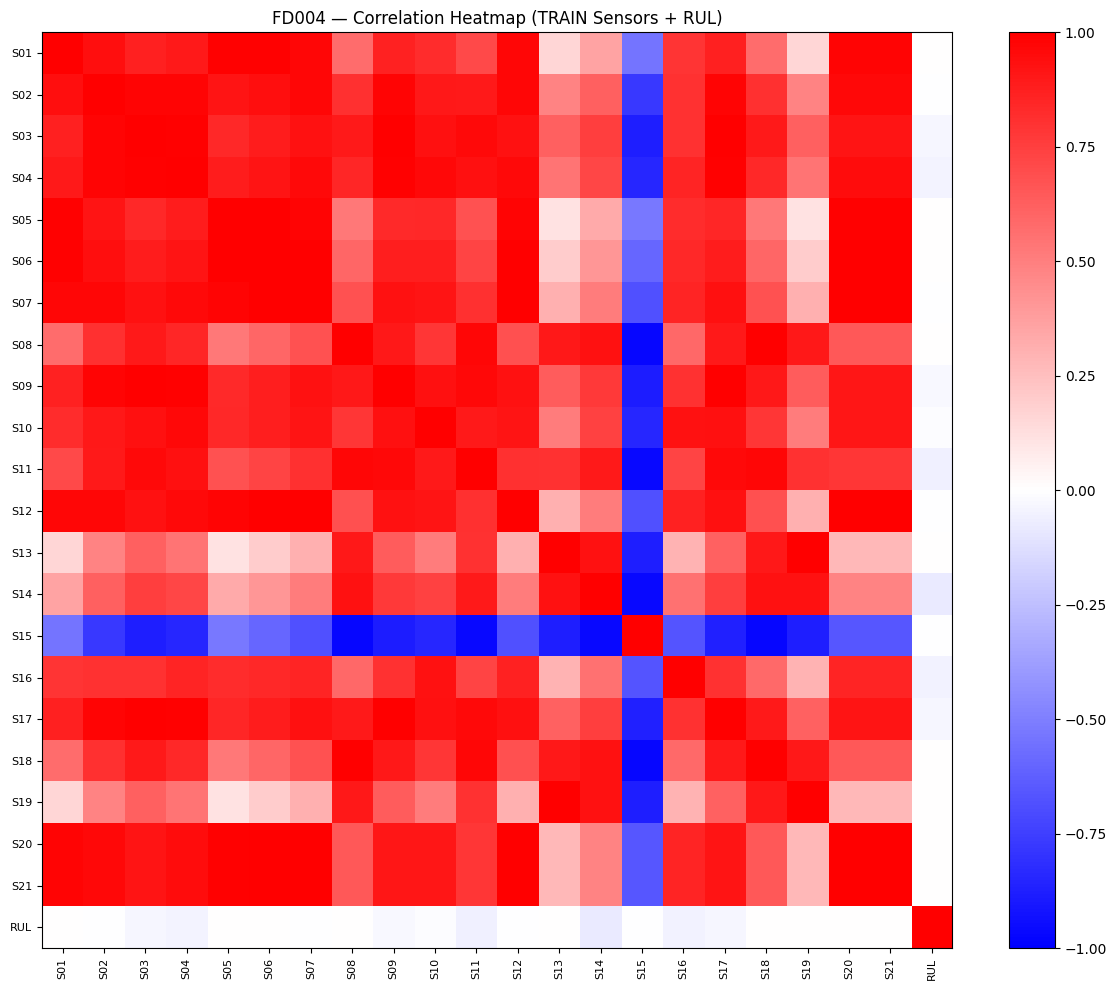


FD004 — Top 10 sensors by |corr with RUL|:


corr_with_RUL
(Corrected core speed) (rpm)             -0.078126
(HPC outlet Static pressure) (psia)      -0.056639
(Burner fuel-air ratio)                  -0.053804
(LPT outlet temperature) (◦R)            -0.045881
(Bleed Enthalpy)                         -0.032939
(HPC outlet temperature) (◦R)            -0.032924
(Physical core speed) (rpm)              -0.024727
(Engine pressure ratio (P50/P2))         -0.008924
(LPC outlet temperature) (◦R)            -0.004443
(Bypass Ratio)                           -0.003957

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FDs = ["FD001", "FD002", "FD003", "FD004"]

# Detect sensor columns (your labeled sensors start with "(" )
sensor_cols = [c for c in cmaps["FD001"]["train"].columns
               if isinstance(c, str) and c.strip().startswith("(")]
if not sensor_cols:
    raise ValueError("No sensor columns detected (expected columns starting with '(').")

# Short labels for readability (S01..S21 + RUL)
short_sensors = [f"S{i:02d}" for i in range(1, len(sensor_cols) + 1)]
short_labels = short_sensors + ["RUL"]

print("\nAxis label map (Sxx -> sensor name):")
for k, name in zip(short_sensors, sensor_cols):
    print(f"{k}: {name}")
print("RUL: Remaining Useful Life (cycles) computed from TRAIN (run-to-failure)")

for fd in FDs:
    # Use TRAIN only (run-to-failure) so we can compute per-row RUL consistently
    train_df = cmaps[fd]["train"].copy()

    # Compute cycle-level RUL for TRAIN: RUL = max_cycle(engine) - cycle
    if "engine_id" not in train_df.columns or "cycle" not in train_df.columns:
        raise ValueError(f"{fd}: 'engine_id' and 'cycle' columns are required to compute RUL.")

    max_cycle = train_df.groupby("engine_id")["cycle"].max()
    train_df["RUL"] = train_df["engine_id"].map(max_cycle) - train_df["cycle"]

    # Correlation among sensors + RUL
    corr_df = train_df[sensor_cols + ["RUL"]]
    corr = corr_df.corr(numeric_only=True)

    plt.figure(figsize=(12, 10))
    im = plt.imshow(corr.values, aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    plt.colorbar(im)
    plt.xticks(range(len(short_labels)), short_labels, rotation=90, fontsize=8)
    plt.yticks(range(len(short_labels)), short_labels, fontsize=8)
    plt.title(f"{fd} — Correlation Heatmap (TRAIN Sensors + RUL)")
    plt.tight_layout()
    plt.show()

    # Optional: print top correlations with RUL for this FD
    rul_corr = corr["RUL"].drop("RUL").sort_values(key=lambda s: s.abs(), ascending=False)
    print(f"\n{fd} — Top 10 sensors by |corr with RUL|:")
    display(rul_corr.head(10).to_frame(name="corr_with_RUL"))


# 7️⃣ Baseline LSTM Model for RUL Prediction (FD001) — Initial Reference Implementation

This step builds an initial LSTM regression baseline to predict Remaining Useful Life (RUL) for the FD001 dataset. The data is split by engine_id to avoid leakage, features are standardized using a scaler fit on the training set only, and the time series is converted into sliding windows (sequence length = 30).

After training with early stopping, the model is evaluated on the test set using the last window per engine (one prediction per engine), and the final plot compares True RUL vs Predicted RUL as a reference point for later model improvements.

Device: cpu
Engines -> train: 80 val: 20
Rows    -> train: 16527 val: 4104
Train sequences: (14207, 30, 24) (14207,)
Val   sequences: (3524, 30, 24) (3524,)
Epoch 01 | train_loss=11811.8617 | val_RMSE=98.095
Epoch 02 | train_loss=7914.3445 | val_RMSE=74.385
Epoch 03 | train_loss=4073.9419 | val_RMSE=47.381
Epoch 04 | train_loss=1732.2093 | val_RMSE=38.292
Epoch 05 | train_loss=1204.4532 | val_RMSE=33.272
Epoch 06 | train_loss=1052.8027 | val_RMSE=32.318
Epoch 07 | train_loss=970.3027 | val_RMSE=32.064
Epoch 08 | train_loss=923.1796 | val_RMSE=31.210
Epoch 09 | train_loss=862.1415 | val_RMSE=32.036
Epoch 10 | train_loss=808.3745 | val_RMSE=32.305
Epoch 11 | train_loss=795.5883 | val_RMSE=32.320
Epoch 12 | train_loss=748.2521 | val_RMSE=32.358
Epoch 13 | train_loss=687.2344 | val_RMSE=31.636
Epoch 14 | train_loss=670.1494 | val_RMSE=31.440
Epoch 15 | train_loss=644.0314 | val_RMSE=32.129
Epoch 16 | train_loss=619.2509 | val_RMSE=32.215
Early stopping.
Best val RMSE: 31.209525546910854
Te

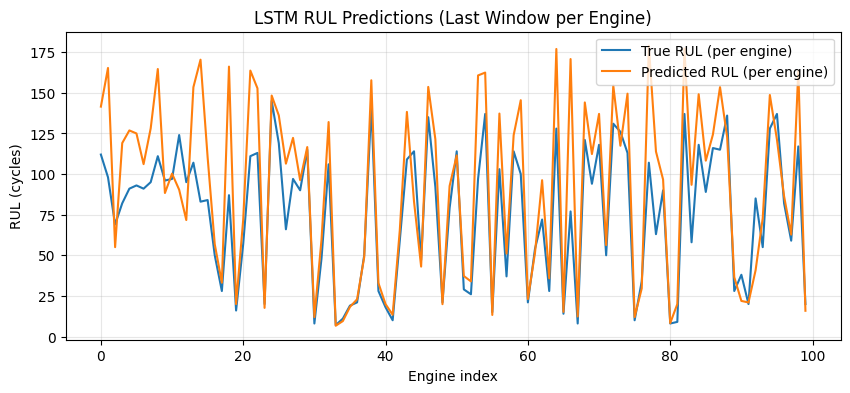

In [7]:
# =========================
# LSTM RUL (PyTorch) - FD001 baseline (strong + clean)  [NO sklearn squared=]
# Requires: train_FD001, test_FD001, SENSOR_NAMES, and RUL already in both dataframes
# =========================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Config
# -------------------------
SEQ_LEN = 30
BATCH_SIZE = 256
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
HIDDEN = 64
NUM_LAYERS = 2
DROPOUT = 0.25
GRAD_CLIP = 1.0

FEATURE_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"] + SENSOR_NAMES
TARGET_COL = "RUL"

# -------------------------
# Helpers: sequences
# -------------------------
def make_sequences(
    df_subset: pd.DataFrame,
    X_scaled: np.ndarray,
    y: np.ndarray,
    seq_len: int = 30,
    last_only: bool = False
):
    """
    df_subset: dataframe aligned row-for-row with X_scaled and y
    X_scaled: 2D array (rows, n_features)
    y: 1D array (rows,)
    last_only: if True -> returns only the LAST window per engine (one sample per engine)
    """
    X_out, y_out = [], []

    # Ensure stable order
    df_subset = df_subset.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    start = 0
    for _, g in df_subset.groupby("engine_id", sort=True):
        n = len(g)
        Xi = X_scaled[start:start + n]
        yi = y[start:start + n]
        start += n

        if n < seq_len:
            continue

        if last_only:
            X_out.append(Xi[-seq_len:])
            y_out.append(yi[-1])
        else:
            for i in range(seq_len - 1, n):
                X_out.append(Xi[i - seq_len + 1:i + 1])
                y_out.append(yi[i])

    return np.asarray(X_out, dtype=np.float32), np.asarray(y_out, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)              # (N, T, F)
        self.y = torch.from_numpy(y).view(-1, 1)  # (N, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------------
# Clean split by engine (no leakage)
# -------------------------
df_all = train_FD001.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

engine_ids = np.sort(df_all["engine_id"].unique())
rng = np.random.default_rng(SEED)
rng.shuffle(engine_ids)

split = int(0.8 * len(engine_ids))
train_ids = engine_ids[:split]
val_ids   = engine_ids[split:]

df_tr = df_all[df_all["engine_id"].isin(train_ids)].copy()
df_va = df_all[df_all["engine_id"].isin(val_ids)].copy()

print("Engines -> train:", len(train_ids), "val:", len(val_ids))
print("Rows    -> train:", len(df_tr), "val:", len(df_va))

# -------------------------
# Scale X (fit on train only)
# y stays in original RUL units (cycles) so RMSE is directly interpretable
# -------------------------
x_scaler = StandardScaler()
X_tr_rows = x_scaler.fit_transform(df_tr[FEATURE_COLS].values)
X_va_rows = x_scaler.transform(df_va[FEATURE_COLS].values)

y_tr_rows = df_tr[TARGET_COL].values.astype(np.float32)
y_va_rows = df_va[TARGET_COL].values.astype(np.float32)

# -------------------------
# Build sequences
# -------------------------
Xtr, ytr = make_sequences(df_tr, X_tr_rows, y_tr_rows, seq_len=SEQ_LEN, last_only=False)
Xva, yva = make_sequences(df_va, X_va_rows, y_va_rows, seq_len=SEQ_LEN, last_only=False)

print("Train sequences:", Xtr.shape, ytr.shape)
print("Val   sequences:", Xva.shape, yva.shape)

train_loader = DataLoader(SeqDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(SeqDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# -------------------------
# Model
# -------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, num_layers=2, dropout=0.25):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)        # (B, T, H)
        last = out[:, -1, :]         # (B, H)
        return self.head(last)       # (B, 1)

model = LSTMRegressor(
    n_features=Xtr.shape[-1],
    hidden=HIDDEN,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

# -------------------------
# Evaluation (RMSE) - FIXED: no squared=
# -------------------------
def eval_rmse(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yp = model(xb)
            preds.append(yp.detach().cpu().numpy().ravel())
            trues.append(yb.detach().cpu().numpy().ravel())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    # sklearn compatibility: compute RMSE manually
    rmse = float(np.sqrt(mean_squared_error(trues, preds)))
    return rmse

# -------------------------
# Train with Early Stopping
# -------------------------
best_val_rmse = np.inf
patience = 8
pat_cnt = 0
best_path = "best_lstm_fd001.pt"

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        yp = model(xb)
        loss = criterion(yp, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        running += loss.item() * xb.size(0)

    train_loss = running / len(train_loader.dataset)
    val_rmse = eval_rmse(val_loader)
    scheduler.step(val_rmse)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_RMSE={val_rmse:.3f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), best_path)
        pat_cnt = 0
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("Early stopping.")
            break

print("Best val RMSE:", best_val_rmse)
model.load_state_dict(torch.load(best_path, map_location=device))

# -------------------------
# Test evaluation (standard): last window per engine
# -------------------------
df_test = test_FD001.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

X_te_rows = x_scaler.transform(df_test[FEATURE_COLS].values)
y_te_rows = df_test[TARGET_COL].values.astype(np.float32)

Xte_last, yte_last = make_sequences(df_test, X_te_rows, y_te_rows, seq_len=SEQ_LEN, last_only=True)

test_loader = DataLoader(SeqDataset(Xte_last, yte_last), batch_size=256, shuffle=False, drop_last=False)

test_rmse = eval_rmse(test_loader)
print("Test RMSE (last window per engine):", test_rmse)

import numpy as np
import matplotlib.pyplot as plt
import torch

def predict_numpy(model, X, batch_size=2048):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size]).to(device)
            yp = model(xb).detach().cpu().numpy().ravel()
            preds.append(yp)
    return np.concatenate(preds)

# ---- Final plot: one prediction per engine (last window per engine) ----
df_plot = test_FD001.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

X_plot_rows = x_scaler.transform(df_plot[FEATURE_COLS].values)
y_plot_rows = df_plot[TARGET_COL].values.astype(np.float32)

X_last, y_true_last = make_sequences(df_plot, X_plot_rows, y_plot_rows, seq_len=SEQ_LEN, last_only=True)
y_pred_last = predict_numpy(model, X_last)

plt.figure(figsize=(10, 4))
plt.plot(y_true_last, label="True RUL (per engine)")
plt.plot(y_pred_last, label="Predicted RUL (per engine)")
plt.title("LSTM RUL Predictions (Last Window per Engine)")
plt.xlabel("Engine index")
plt.ylabel("RUL (cycles)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Conservative LSTM Modeling (FD001–FD004): Objective and Strategy


# 8️⃣ **Environment Setup, Reproducibility, and Global Hyperparameters**

This cell imports the required libraries for data handling, preprocessing, modeling, and visualization (NumPy, Pandas, Matplotlib, Scikit-learn, and PyTorch). To ensure consistent and repeatable results, we fix the random seed and configure PyTorch deterministic behavior. We also detect whether training will run on **GPU (CUDA)** or **CPU**.

Finally, we define the global hyperparameters for the LSTM experiment, including sequence length, batch size, learning rate, regularization, and model architecture settings. The **conservative controls** (`OVER_WEIGHT` and `ALPHA`) govern how strongly we penalize over-estimation during training and how conservative the validation-based safety margin will be. The feature set is defined as the operating settings plus the 21 sensor signals, with `RUL` as the prediction target.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Global Config
# -------------------------
SEQ_LEN = 30
BATCH_SIZE = 256
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
HIDDEN = 64
NUM_LAYERS = 2
DROPOUT = 0.25
GRAD_CLIP = 1.0

# Conservative controls
OVER_WEIGHT = 5.0   # >1 penalizes over-prediction more than under-prediction
ALPHA = 0.05        # one-sided calibration: target ~95% "pred <= true" on validation

FEATURE_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"] + SENSOR_NAMES
TARGET_COL = "RUL"


Device: cpu


# 9️⃣ **Sequence Generation and PyTorch Dataset Construction**

This cell prepares the time-series data for LSTM modeling by converting each engine’s trajectory into fixed-length sequences.

- `make_sequences(...)` sorts the data by `engine_id` and `cycle`, then builds sliding windows of length `seq_len` (e.g., 30 cycles).  
  - Each input sample \(X\) is a window of sensor/setting values.
  - The target \(y\) is the **RUL at the final cycle** of that window.
  - If `last_only=True`, only the **last window per engine** is returned (standard for test evaluation: one prediction per engine).

- `SeqDataset` wraps the resulting arrays into a PyTorch `Dataset` so they can be fed into a `DataLoader` for efficient mini-batch training and evaluation.


In [9]:
def make_sequences(df_subset, X_scaled, y, seq_len=30, last_only=False):
    X_out, y_out = [], []
    df_subset = df_subset.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    start = 0
    for _, g in df_subset.groupby("engine_id", sort=True):
        n = len(g)
        Xi = X_scaled[start:start + n]
        yi = y[start:start + n]
        start += n

        if n < seq_len:
            continue

        if last_only:
            X_out.append(Xi[-seq_len:])
            y_out.append(yi[-1])
        else:
            for i in range(seq_len - 1, n):
                X_out.append(Xi[i - seq_len + 1:i + 1])
                y_out.append(yi[i])

    return np.asarray(X_out, dtype=np.float32), np.asarray(y_out, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# 🔟 **End-to-End Training Function for One FD Set (Train → Validate → Calibrate → Test)**

This cell defines `train_one_fd(...)`, which runs the complete conservative LSTM workflow for a single dataset (e.g., FD001, FD002, FD003, or FD004).

Key actions performed inside the function:

- **Leakage-free split:** The training data is split by `engine_id` into training and validation sets to ensure the model is validated on unseen engines.
- **Feature scaling:** `StandardScaler` is fit on the training subset only, then applied to validation and test data.
- **Sequence generation:** The time-series is converted into fixed-length sliding windows for LSTM input. For testing, only the **last window per engine** is used (one prediction per engine).
- **Model training:** An LSTM regressor is trained using a conservative (asymmetric) loss, with AdamW optimization, learning-rate scheduling, gradient clipping, and early stopping based on validation RMSE.
- **Conservative calibration:** A one-sided safety margin \(t\) is computed from validation residuals and used to shift predictions downward:  
  $$\widehat{\mathrm{RUL}}_{\mathrm{safe}} = \widehat{\mathrm{RUL}}_{\mathrm{raw}} - t$$
- **Outputs:** The function returns a results dictionary containing the best validation RMSE, calibration margin \(t\), test metrics (RMSE and over-estimation rate for raw vs safe predictions), predictions for plotting, and the saved model path.


In [12]:
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, num_layers=2, dropout=0.25):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)

def conservative_loss(pred, true, over_weight=5.0):
    diff = pred - true
    w = torch.where(
        diff > 0,
        torch.tensor(over_weight, device=pred.device),
        torch.tensor(1.0, device=pred.device),
    )
    return torch.mean(w * diff**2)

def predict_numpy(model, X, batch_size=2048):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size]).to(device)
            yp = model(xb).detach().cpu().numpy().ravel()
            preds.append(yp)
    return np.concatenate(preds)

def rmse_np(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def over_rate(y_true, y_pred):
    return float(np.mean((y_pred - y_true) > 0))


# 1️⃣1️⃣ One FD training function (split → scale → sequence → train → calibrate → test)

In [13]:
def train_one_fd(fd_name, train_df, test_df):
    # -------- split by engine_id (no leakage)
    df_all = train_df.sort_values(["engine_id", "cycle"]).reset_index(drop=True)
    engine_ids = np.sort(df_all["engine_id"].unique())

    rng = np.random.default_rng(SEED)
    rng.shuffle(engine_ids)

    split = int(0.8 * len(engine_ids))
    train_ids = engine_ids[:split]
    val_ids   = engine_ids[split:]

    df_tr = df_all[df_all["engine_id"].isin(train_ids)].copy()
    df_va = df_all[df_all["engine_id"].isin(val_ids)].copy()

    # -------- scale X (fit on train only)
    x_scaler = StandardScaler()
    X_tr_rows = x_scaler.fit_transform(df_tr[FEATURE_COLS].values)
    X_va_rows = x_scaler.transform(df_va[FEATURE_COLS].values)

    y_tr_rows = df_tr[TARGET_COL].values.astype(np.float32)
    y_va_rows = df_va[TARGET_COL].values.astype(np.float32)

    # -------- sequences (train/val)
    Xtr, ytr = make_sequences(df_tr, X_tr_rows, y_tr_rows, seq_len=SEQ_LEN, last_only=False)
    Xva, yva = make_sequences(df_va, X_va_rows, y_va_rows, seq_len=SEQ_LEN, last_only=False)

    train_loader = DataLoader(SeqDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader   = DataLoader(SeqDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # -------- model
    model = LSTMRegressor(n_features=Xtr.shape[-1], hidden=HIDDEN, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    # -------- eval rmse on loader
    def eval_rmse_loader(loader):
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                yb = yb.to(device)
                yp = model(xb)
                preds.append(yp.detach().cpu().numpy().ravel())
                trues.append(yb.detach().cpu().numpy().ravel())
        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        return rmse_np(trues, preds)

    # -------- train with early stopping
    best_val_rmse = np.inf
    patience = 8
    pat_cnt = 0
    best_path = f"best_lstm_{fd_name}_conservative.pt"

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            yp = model(xb)
            loss = conservative_loss(yp, yb, over_weight=OVER_WEIGHT)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            running += loss.item() * xb.size(0)

        train_loss = running / len(train_loader.dataset)
        val_rmse = eval_rmse_loader(val_loader)
        scheduler.step(val_rmse)

        print(f"{fd_name} | Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_RMSE={val_rmse:.3f}")

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), best_path)
            pat_cnt = 0
        else:
            pat_cnt += 1
            if pat_cnt >= patience:
                print(f"{fd_name} | Early stopping.")
                break

    model.load_state_dict(torch.load(best_path, map_location=device))

    # -------- calibrate conservative margin on validation
    yva_pred = predict_numpy(model, Xva)
    residual_over = yva_pred - yva
    t = float(np.quantile(residual_over, 1 - ALPHA))

    # -------- test (last window per engine)
    df_test = test_df.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    X_te_rows = x_scaler.transform(df_test[FEATURE_COLS].values)
    y_te_rows = df_test[TARGET_COL].values.astype(np.float32)

    Xte_last, yte_last = make_sequences(df_test, X_te_rows, y_te_rows, seq_len=SEQ_LEN, last_only=True)

    y_pred_last = predict_numpy(model, Xte_last)
    y_pred_last_safe = y_pred_last - t

    # -------- metrics
    out = {
        "fd": fd_name,
        "val_best_rmse": float(best_val_rmse),
        "calib_margin_t": float(t),
        "test_rmse_raw": rmse_np(yte_last, y_pred_last),
        "test_rmse_safe": rmse_np(yte_last, y_pred_last_safe),
        "test_overrate_raw": over_rate(yte_last, y_pred_last),
        "test_overrate_safe": over_rate(yte_last, y_pred_last_safe),
        "y_true_last": yte_last,
        "y_pred_last": y_pred_last,
        "y_pred_last_safe": y_pred_last_safe,
        "model_path": best_path,
    }
    return out


# 1️⃣2️⃣ **Run Conservative LSTM Training for FD001–FD004 and Collect Results**

This cell loops through the four C-MAPSS subsets (FD001–FD004) and applies the `train_one_fd(...)` function to each dataset. For every FD set, the code trains a separate conservative LSTM model, calibrates the conservative margin, and evaluates test performance using the last window per engine.

All outputs are stored in:
- `results`: a dictionary containing detailed outputs for each FD set (predictions, calibration margin, metrics, and model path).
- `summary_rows`: a structured list of key metrics (validation RMSE, calibration margin, test RMSE, and over-estimation rates) to later create a summary comparison table across FD001–FD004.



In [14]:
results = {}
summary_rows = []

for fd in ["FD001", "FD002", "FD003", "FD004"]:
    train_df = globals()[f"train_{fd}"]
    test_df  = globals()[f"test_{fd}"]

    print("\n" + "="*70)
    print(f"Training Conservative LSTM for {fd}")
    print("="*70)

    res = train_one_fd(fd, train_df, test_df)
    results[fd] = res

    summary_rows.append({
        "FD": fd,
        "Val Best RMSE": res["val_best_rmse"],
        "Calib margin t": res["calib_margin_t"],
        "Test RMSE (raw)": res["test_rmse_raw"],
        "Test RMSE (safe)": res["test_rmse_safe"],
        "Over-rate (raw)": res["test_overrate_raw"],
        "Over-rate (safe)": res["test_overrate_safe"],
        "Saved model": res["model_path"],
    })



Training Conservative LSTM for FD001
FD001 | Epoch 01 | train_loss=11809.3294 | val_RMSE=98.145
FD001 | Epoch 02 | train_loss=7980.9223 | val_RMSE=74.661
FD001 | Epoch 03 | train_loss=4227.6855 | val_RMSE=49.108
FD001 | Epoch 04 | train_loss=2313.3381 | val_RMSE=40.129
FD001 | Epoch 05 | train_loss=1862.2869 | val_RMSE=41.432
FD001 | Epoch 06 | train_loss=1704.6686 | val_RMSE=41.102
FD001 | Epoch 07 | train_loss=1625.0246 | val_RMSE=35.808
FD001 | Epoch 08 | train_loss=1548.9801 | val_RMSE=37.081
FD001 | Epoch 09 | train_loss=1511.9941 | val_RMSE=39.993
FD001 | Epoch 10 | train_loss=1468.1450 | val_RMSE=37.590
FD001 | Epoch 11 | train_loss=1429.6359 | val_RMSE=37.079
FD001 | Epoch 12 | train_loss=1346.3428 | val_RMSE=39.413
FD001 | Epoch 13 | train_loss=1318.8469 | val_RMSE=37.559
FD001 | Epoch 14 | train_loss=1285.6952 | val_RMSE=38.945
FD001 | Epoch 15 | train_loss=1219.8389 | val_RMSE=41.346
FD001 | Early stopping.

Training Conservative LSTM for FD002
FD002 | Epoch 01 | train_loss

# 1️⃣3️⃣ Plot results for each FD

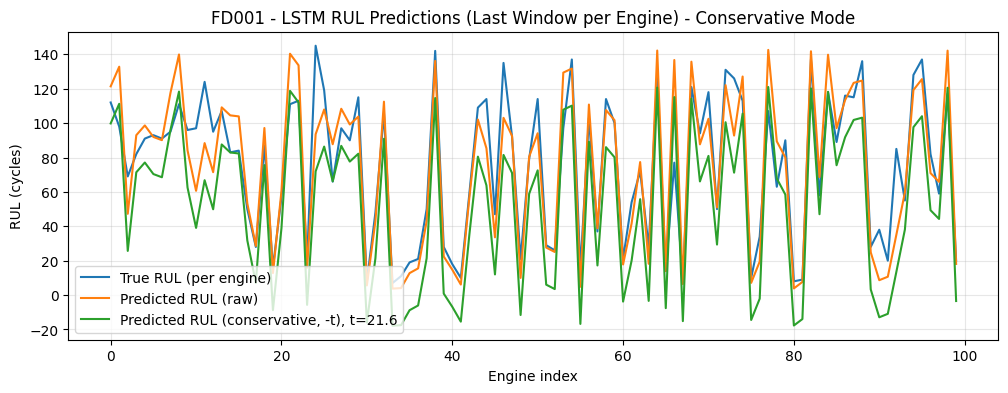

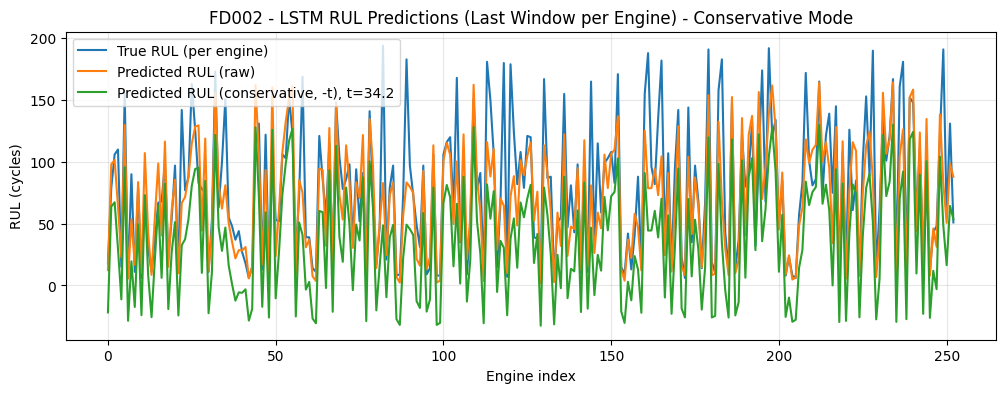

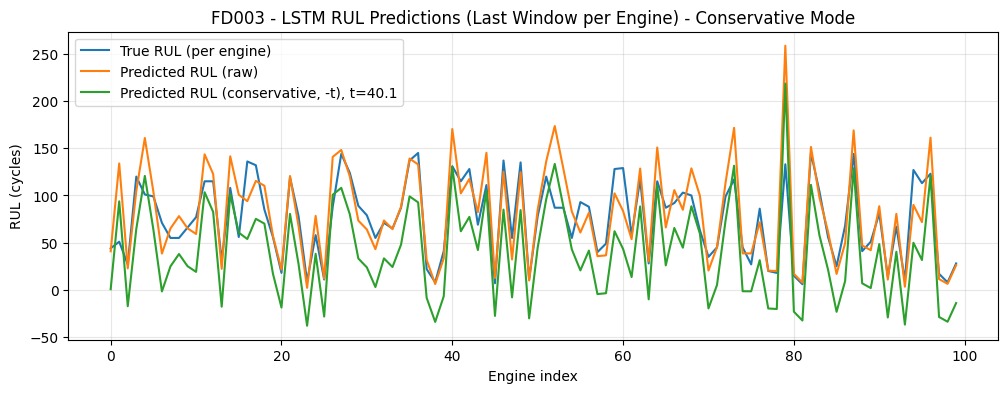

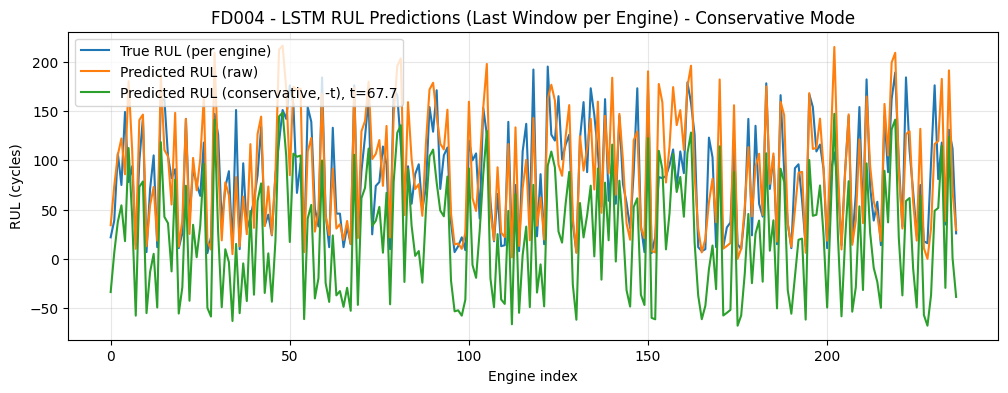

In [15]:
for fd in ["FD001", "FD002", "FD003", "FD004"]:
    res = results[fd]

    y_true = res["y_true_last"]
    y_raw  = res["y_pred_last"]
    y_safe = res["y_pred_last_safe"]
    t = res["calib_margin_t"]

    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True RUL (per engine)")
    plt.plot(y_raw,  label="Predicted RUL (raw)")
    plt.plot(y_safe, label=f"Predicted RUL (conservative, -t), t={t:.1f}")
    plt.title(f"{fd} - LSTM RUL Predictions (Last Window per Engine) - Conservative Mode")
    plt.xlabel("Engine index")
    plt.ylabel("RUL (cycles)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# 1️⃣4️⃣ Summary table

In [16]:
summary = pd.DataFrame(summary_rows)
display(summary)

FD  Val Best RMSE  Calib margin t  Test RMSE (raw)  Test RMSE (safe)  \
0  FD001      35.807970       21.572552        17.404440         28.387477   
1  FD002      37.723418       34.205475        32.646401         53.778272   
2  FD003      56.353525       40.124363        26.896889         44.007734   
3  FD004      46.414225       67.718987        35.917367         70.556659   

   Over-rate (raw)  Over-rate (safe)                      Saved model  
0         0.410000          0.110000  best_lstm_FD001_conservative.pt  
1         0.375494          0.051383  best_lstm_FD002_conservative.pt  
2         0.520000          0.080000  best_lstm_FD003_conservative.pt  
3         0.582278          0.054852  best_lstm_FD004_conservative.pt

# 1️⃣5️⃣ **Model Comparison Across FD001–FD004: LSTM vs LSTM+RNN**

This cell performs a systematic comparison between two deep sequence models for RUL prediction across all four C-MAPSS subsets (**FD001–FD004**):

- **Model 1:** LSTM regressor  
- **Model 2:** Hybrid LSTM+RNN regressor (LSTM outputs are passed into an additional RNN layer)

For each FD set, the workflow is identical:
- Split the training data by **engine_id** to prevent leakage (validation engines are unseen during training).
- Standardize features using `StandardScaler` fit only on the training subset.
- Convert engine trajectories into fixed-length **sequence windows** for LSTM-based learning.
- Train both models with early stopping based on **validation RMSE**.
- Evaluate on the test set using the **last window per engine** (one prediction per engine).
- Generate a comparison plot (True RUL vs predicted RUL) and store results.

Finally, the code compiles a **summary table** that reports validation and test RMSE for both models and records the saved model files, enabling direct performance comparison across FD001–FD004.


Device: cpu

FD SET: FD001 | LSTM vs LSTM+RNN
Engines -> train: 80 val: 20
Rows    -> train: 16527 val: 4104

--- Training LSTM ---
LSTM_FD001 | Epoch 01 | train_loss=11811.8617 | val_RMSE=98.095
LSTM_FD001 | Epoch 02 | train_loss=7914.3445 | val_RMSE=74.385
LSTM_FD001 | Epoch 03 | train_loss=4073.9419 | val_RMSE=47.381
LSTM_FD001 | Epoch 04 | train_loss=1732.2093 | val_RMSE=38.292
LSTM_FD001 | Epoch 05 | train_loss=1204.4532 | val_RMSE=33.272
LSTM_FD001 | Epoch 06 | train_loss=1052.8027 | val_RMSE=32.318
LSTM_FD001 | Epoch 07 | train_loss=970.3027 | val_RMSE=32.064
LSTM_FD001 | Epoch 08 | train_loss=923.1796 | val_RMSE=31.210
LSTM_FD001 | Epoch 09 | train_loss=862.1415 | val_RMSE=32.036
LSTM_FD001 | Epoch 10 | train_loss=808.3745 | val_RMSE=32.305
LSTM_FD001 | Epoch 11 | train_loss=795.5883 | val_RMSE=32.320
LSTM_FD001 | Epoch 12 | train_loss=748.2521 | val_RMSE=32.358
LSTM_FD001 | Epoch 13 | train_loss=687.2344 | val_RMSE=31.636
LSTM_FD001 | Epoch 14 | train_loss=670.1494 | val_RMSE=

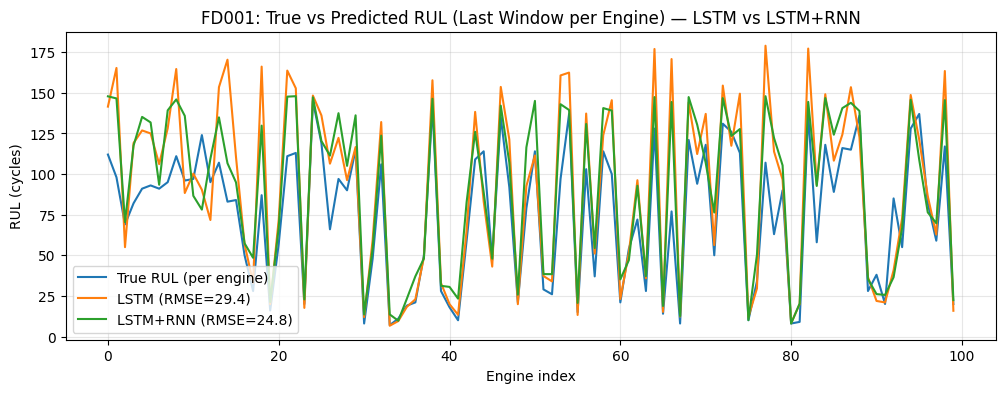


FD SET: FD002 | LSTM vs LSTM+RNN
Engines -> train: 208 val: 52
Rows    -> train: 43301 val: 10458

--- Training LSTM ---
LSTM_FD002 | Epoch 01 | train_loss=9575.0551 | val_RMSE=63.831
LSTM_FD002 | Epoch 02 | train_loss=4133.4660 | val_RMSE=58.311
LSTM_FD002 | Epoch 03 | train_loss=3862.8071 | val_RMSE=49.881
LSTM_FD002 | Epoch 04 | train_loss=2249.0155 | val_RMSE=41.007
LSTM_FD002 | Epoch 05 | train_loss=1766.7923 | val_RMSE=39.204
LSTM_FD002 | Epoch 06 | train_loss=1655.9758 | val_RMSE=39.196
LSTM_FD002 | Epoch 07 | train_loss=1556.8786 | val_RMSE=38.650
LSTM_FD002 | Epoch 08 | train_loss=1518.3717 | val_RMSE=37.372
LSTM_FD002 | Epoch 09 | train_loss=1453.7968 | val_RMSE=37.146
LSTM_FD002 | Epoch 10 | train_loss=1410.7903 | val_RMSE=37.220
LSTM_FD002 | Epoch 11 | train_loss=1349.0593 | val_RMSE=36.990
LSTM_FD002 | Epoch 12 | train_loss=1314.9462 | val_RMSE=37.289
LSTM_FD002 | Epoch 13 | train_loss=1295.4948 | val_RMSE=37.115
LSTM_FD002 | Epoch 14 | train_loss=1244.4411 | val_RMSE=36.

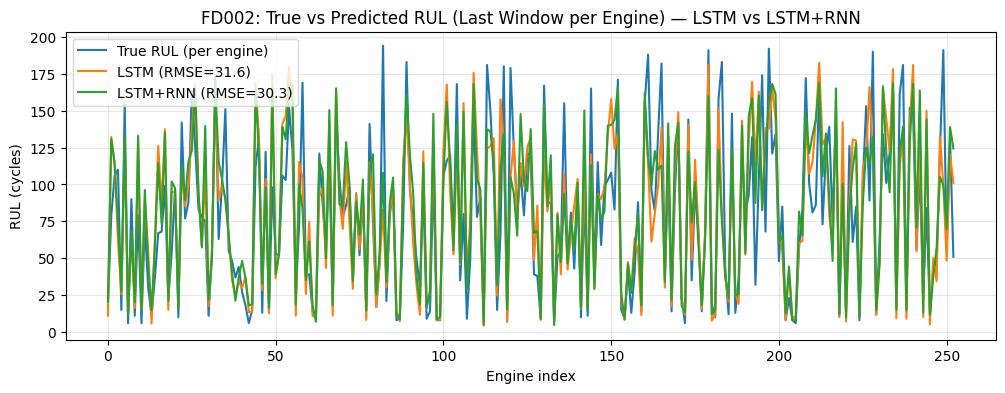


FD SET: FD003 | LSTM vs LSTM+RNN
Engines -> train: 80 val: 20
Rows    -> train: 19842 val: 4878

--- Training LSTM ---
LSTM_FD003 | Epoch 01 | train_loss=23489.5608 | val_RMSE=137.066
LSTM_FD003 | Epoch 02 | train_loss=17159.0456 | val_RMSE=107.981
LSTM_FD003 | Epoch 03 | train_loss=10068.5907 | val_RMSE=75.346
LSTM_FD003 | Epoch 04 | train_loss=4942.6361 | val_RMSE=55.596
LSTM_FD003 | Epoch 05 | train_loss=3125.1001 | val_RMSE=53.309
LSTM_FD003 | Epoch 06 | train_loss=2435.0106 | val_RMSE=54.161
LSTM_FD003 | Epoch 07 | train_loss=2055.6258 | val_RMSE=60.448
LSTM_FD003 | Epoch 08 | train_loss=1830.9006 | val_RMSE=53.179
LSTM_FD003 | Epoch 09 | train_loss=1699.7303 | val_RMSE=55.590
LSTM_FD003 | Epoch 10 | train_loss=1580.6138 | val_RMSE=54.326
LSTM_FD003 | Epoch 11 | train_loss=1526.8389 | val_RMSE=55.889
LSTM_FD003 | Epoch 12 | train_loss=1414.2354 | val_RMSE=58.966
LSTM_FD003 | Epoch 13 | train_loss=1333.8408 | val_RMSE=56.295
LSTM_FD003 | Epoch 14 | train_loss=1252.2021 | val_RMSE=

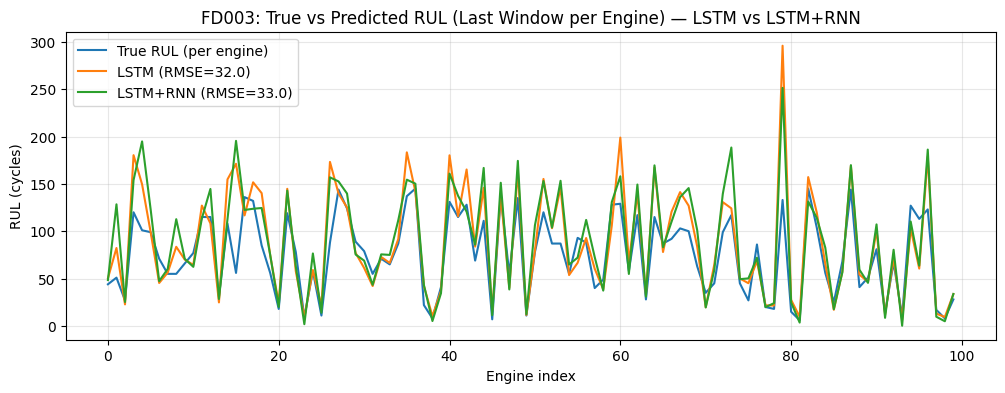


FD SET: FD004 | LSTM vs LSTM+RNN
Engines -> train: 199 val: 50
Rows    -> train: 49521 val: 11728

--- Training LSTM ---
LSTM_FD004 | Epoch 01 | train_loss=15979.8391 | val_RMSE=78.181
LSTM_FD004 | Epoch 02 | train_loss=7431.6515 | val_RMSE=75.315
LSTM_FD004 | Epoch 03 | train_loss=6856.3924 | val_RMSE=56.813
LSTM_FD004 | Epoch 04 | train_loss=4221.1391 | val_RMSE=50.381
LSTM_FD004 | Epoch 05 | train_loss=3566.0473 | val_RMSE=49.768
LSTM_FD004 | Epoch 06 | train_loss=3343.8689 | val_RMSE=48.599
LSTM_FD004 | Epoch 07 | train_loss=3218.0980 | val_RMSE=46.426
LSTM_FD004 | Epoch 08 | train_loss=3111.8574 | val_RMSE=46.136
LSTM_FD004 | Epoch 09 | train_loss=2987.5040 | val_RMSE=46.234
LSTM_FD004 | Epoch 10 | train_loss=2847.0153 | val_RMSE=46.650
LSTM_FD004 | Epoch 11 | train_loss=2767.7721 | val_RMSE=49.648
LSTM_FD004 | Epoch 12 | train_loss=2658.5888 | val_RMSE=51.015
LSTM_FD004 | Epoch 13 | train_loss=2523.5953 | val_RMSE=48.293
LSTM_FD004 | Epoch 14 | train_loss=2431.6915 | val_RMSE=50

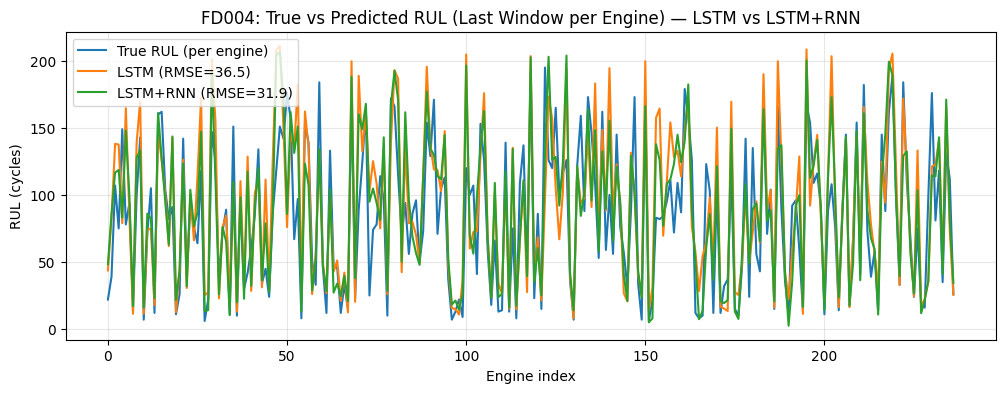

FD  Val RMSE (LSTM)  Val RMSE (LSTM+RNN)  Test RMSE (LSTM)  \
0  FD001        31.209526            32.617991         29.412998   
1  FD002        36.371511            35.718593         31.594682   
2  FD003        53.179113            49.409264         32.020587   
3  FD004        46.136021            45.425691         36.526485   

   Test RMSE (LSTM+RNN)          Saved LSTM          Saved LSTM+RNN  
0             24.842348  best_LSTM_FD001.pt  best_LSTM_RNN_FD001.pt  
1             30.343881  best_LSTM_FD002.pt  best_LSTM_RNN_FD002.pt  
2             33.037639  best_LSTM_FD003.pt  best_LSTM_RNN_FD003.pt  
3             31.854543  best_LSTM_FD004.pt  best_LSTM_RNN_FD004.pt

In [17]:
# =========================
# Compare: (1) LSTM vs (2) LSTM + RNN  (FD001..FD004) + Final Plots + Summary Table
# Requires: train_FD001..train_FD004, test_FD001..test_FD004, SENSOR_NAMES, and RUL already in both dataframes
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Config
# -------------------------
SEQ_LEN = 30
BATCH_SIZE = 256
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE = 8

# Model sizes (you can tune)
LSTM_HIDDEN = 64
LSTM_LAYERS = 2
LSTM_DROPOUT = 0.25

RNN_HIDDEN = 32
RNN_LAYERS = 1
RNN_DROPOUT = 0.0

FEATURE_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"] + SENSOR_NAMES
TARGET_COL = "RUL"

FDs = ["FD001", "FD002", "FD003", "FD004"]

# -------------------------
# Helpers: sequences + dataset
# -------------------------
def make_sequences(df_subset, X_scaled, y, seq_len=30, last_only=False):
    X_out, y_out = [], []
    df_subset = df_subset.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    start = 0
    for _, g in df_subset.groupby("engine_id", sort=True):
        n = len(g)
        Xi = X_scaled[start:start + n]
        yi = y[start:start + n]
        start += n

        if n < seq_len:
            continue

        if last_only:
            X_out.append(Xi[-seq_len:])
            y_out.append(yi[-1])
        else:
            for i in range(seq_len - 1, n):
                X_out.append(Xi[i - seq_len + 1:i + 1])
                y_out.append(yi[i])

    return np.asarray(X_out, dtype=np.float32), np.asarray(y_out, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)              # (N, T, F)
        self.y = torch.from_numpy(y).view(-1, 1)  # (N, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def rmse_np(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))  # no squared=

def predict_numpy(model, X, batch_size=2048):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size]).to(device)
            yp = model(xb).detach().cpu().numpy().ravel()
            preds.append(yp)
    return np.concatenate(preds)

# -------------------------
# Models
# -------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, num_layers=2, dropout=0.25):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)      # (B, T, H)
        last = out[:, -1, :]       # (B, H)
        return self.head(last)     # (B, 1)

class LSTM_RNN_Regressor(nn.Module):
    """
    LSTM -> RNN -> Dense head
    (RNN sees the full sequence output of the LSTM)
    """
    def __init__(self, n_features, lstm_hidden=64, lstm_layers=2, lstm_dropout=0.25,
                 rnn_hidden=32, rnn_layers=1, rnn_dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0.0,
        )
        self.rnn = nn.RNN(
            input_size=lstm_hidden,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            nonlinearity="tanh",
            batch_first=True,
            dropout=rnn_dropout if rnn_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(lstm_dropout),
            nn.Linear(rnn_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        z, _ = self.lstm(x)        # (B, T, lstm_hidden)
        out, _ = self.rnn(z)       # (B, T, rnn_hidden)
        last = out[:, -1, :]       # (B, rnn_hidden)
        return self.head(last)     # (B, 1)

# -------------------------
# Training routine (shared)
# -------------------------
def eval_rmse_loader(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yp = model(xb)
            preds.append(yp.detach().cpu().numpy().ravel())
            trues.append(yb.detach().cpu().numpy().ravel())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return rmse_np(trues, preds)

def train_model(model, train_loader, val_loader, name="model"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    best_val = np.inf
    pat = 0
    best_path = f"best_{name}.pt"

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            yp = model(xb)
            loss = criterion(yp, yb)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            running += loss.item() * xb.size(0)

        train_loss = running / len(train_loader.dataset)
        val_rmse = eval_rmse_loader(model, val_loader)
        scheduler.step(val_rmse)

        print(f"{name} | Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_RMSE={val_rmse:.3f}")

        if val_rmse < best_val:
            best_val = val_rmse
            torch.save(model.state_dict(), best_path)
            pat = 0
        else:
            pat += 1
            if pat >= PATIENCE:
                print(f"{name} | Early stopping.")
                break

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model, best_val, best_path

# -------------------------
# Run for FD001..FD004
# -------------------------
summary_rows = []
all_results = {}

for fd in FDs:
    print("\n" + "="*80)
    print(f"FD SET: {fd} | LSTM vs LSTM+RNN")
    print("="*80)

    train_df = globals()[f"train_{fd}"].sort_values(["engine_id", "cycle"]).reset_index(drop=True)
    test_df  = globals()[f"test_{fd}"].sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    # ---- Split by engine_id (no leakage)
    engine_ids = np.sort(train_df["engine_id"].unique())
    rng = np.random.default_rng(SEED)
    rng.shuffle(engine_ids)

    split = int(0.8 * len(engine_ids))
    train_ids = engine_ids[:split]
    val_ids   = engine_ids[split:]

    df_tr = train_df[train_df["engine_id"].isin(train_ids)].copy()
    df_va = train_df[train_df["engine_id"].isin(val_ids)].copy()

    print("Engines -> train:", len(train_ids), "val:", len(val_ids))
    print("Rows    -> train:", len(df_tr), "val:", len(df_va))

    # ---- Scale X (fit on train only)
    x_scaler = StandardScaler()
    X_tr_rows = x_scaler.fit_transform(df_tr[FEATURE_COLS].values)
    X_va_rows = x_scaler.transform(df_va[FEATURE_COLS].values)

    y_tr_rows = df_tr[TARGET_COL].values.astype(np.float32)
    y_va_rows = df_va[TARGET_COL].values.astype(np.float32)

    # ---- Build sequences (train/val)
    Xtr, ytr = make_sequences(df_tr, X_tr_rows, y_tr_rows, seq_len=SEQ_LEN, last_only=False)
    Xva, yva = make_sequences(df_va, X_va_rows, y_va_rows, seq_len=SEQ_LEN, last_only=False)

    train_loader = DataLoader(SeqDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader   = DataLoader(SeqDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    # ---- Train LSTM
    lstm = LSTMRegressor(
        n_features=Xtr.shape[-1],
        hidden=LSTM_HIDDEN,
        num_layers=LSTM_LAYERS,
        dropout=LSTM_DROPOUT
    ).to(device)

    print("\n--- Training LSTM ---")
    lstm, best_val_lstm, path_lstm = train_model(lstm, train_loader, val_loader, name=f"LSTM_{fd}")

    # ---- Train LSTM+RNN
    lstm_rnn = LSTM_RNN_Regressor(
        n_features=Xtr.shape[-1],
        lstm_hidden=LSTM_HIDDEN,
        lstm_layers=LSTM_LAYERS,
        lstm_dropout=LSTM_DROPOUT,
        rnn_hidden=RNN_HIDDEN,
        rnn_layers=RNN_LAYERS,
        rnn_dropout=RNN_DROPOUT
    ).to(device)

    print("\n--- Training LSTM + RNN ---")
    lstm_rnn, best_val_lstm_rnn, path_lstm_rnn = train_model(lstm_rnn, train_loader, val_loader, name=f"LSTM_RNN_{fd}")

    print("\nBest validation RMSE:")
    print("LSTM      :", best_val_lstm)
    print("LSTM + RNN :", best_val_lstm_rnn)

    # ---- Test (last window per engine)
    X_te_rows = x_scaler.transform(test_df[FEATURE_COLS].values)
    y_te_rows = test_df[TARGET_COL].values.astype(np.float32)

    X_last, y_true_last = make_sequences(test_df, X_te_rows, y_te_rows, seq_len=SEQ_LEN, last_only=True)

    y_pred_lstm = predict_numpy(lstm, X_last)
    y_pred_lstm_rnn = predict_numpy(lstm_rnn, X_last)

    rmse_lstm = rmse_np(y_true_last, y_pred_lstm)
    rmse_lstm_rnn = rmse_np(y_true_last, y_pred_lstm_rnn)

    print("\nTest RMSE (last window per engine):")
    print("LSTM      :", rmse_lstm)
    print("LSTM + RNN:", rmse_lstm_rnn)

    # ---- Plot comparison
    plt.figure(figsize=(12, 4))
    plt.plot(y_true_last, label="True RUL (per engine)")
    plt.plot(y_pred_lstm, label=f"LSTM (RMSE={rmse_lstm:.1f})")
    plt.plot(y_pred_lstm_rnn, label=f"LSTM+RNN (RMSE={rmse_lstm_rnn:.1f})")
    plt.title(f"{fd}: True vs Predicted RUL (Last Window per Engine) — LSTM vs LSTM+RNN")
    plt.xlabel("Engine index")
    plt.ylabel("RUL (cycles)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # ---- Store results
    all_results[fd] = {
        "best_val_rmse_lstm": best_val_lstm,
        "best_val_rmse_lstm_rnn": best_val_lstm_rnn,
        "test_rmse_lstm": rmse_lstm,
        "test_rmse_lstm_rnn": rmse_lstm_rnn,
        "y_true_last": y_true_last,
        "y_pred_lstm": y_pred_lstm,
        "y_pred_lstm_rnn": y_pred_lstm_rnn,
        "model_path_lstm": path_lstm,
        "model_path_lstm_rnn": path_lstm_rnn,
    }

    summary_rows.append({
        "FD": fd,
        "Val RMSE (LSTM)": best_val_lstm,
        "Val RMSE (LSTM+RNN)": best_val_lstm_rnn,
        "Test RMSE (LSTM)": rmse_lstm,
        "Test RMSE (LSTM+RNN)": rmse_lstm_rnn,
        "Saved LSTM": path_lstm,
        "Saved LSTM+RNN": path_lstm_rnn,
    })

# -------------------------
# Summary table across FD001..FD004
# -------------------------
summary = pd.DataFrame(summary_rows)
display(summary)


# ✅ **Conclusion — RUL Estimation Results (FD001–FD004)**

In this phase, we developed deep learning models to estimate the Remaining Useful Life (RUL) of turbofan engines using the NASA C-MAPSS dataset. Using an engine-level (no-leakage) train/validation split and evaluating on the test set via the last available window per engine, we trained and compared two sequence models: (1) an LSTM regressor and (2) a hybrid LSTM+RNN regressor.

The results show that both architectures can learn meaningful degradation patterns and produce reasonable RUL estimates. However, performance is not fully consistent across FD sets, indicating that the “best” architecture may depend on the operating regime and fault characteristics of each subset, and that a single validation split can introduce variance in model selection.

Therefore, the RUL prediction task is considered successfully completed at this stage, and the next phase of the project will focus on translating the predicted RUL into reliability/maintenance insights (e.g., inspection thresholds, preventive maintenance triggers, and risk-aware decision rules).


# 🚀 Above & Beyond: GroupKFold Cross-Validation (Engine-Wise) + Model Comparison Plots (LSTM vs LSTM+RNN)

In this block, we perform **leakage-free cross-validation** for the C-MAPSS datasets (FD001–FD004) by splitting the training data **by engine_id** using **GroupKFold (K = 5)**. This ensures that **all cycles from a given engine** belong to either the training fold or the validation fold (never both), which provides a realistic generalization test for unseen engines.

### What this experiment produces
For each FD subset and for each fold, the code reports and stores:
- **Validation RMSE** and **Test RMSE** for:
  1) a baseline **LSTM regressor**
  2) a hybrid **LSTM + RNN regressor**
- A **mean ± std** summary of RMSE across the 5 folds (stability/consistency indicator)
- A final FD-level plot using the **K-fold ensemble mean prediction** (average of the 5 fold test predictions)

### Key implementation details (important for correctness)
- **Scaling without leakage:** a `StandardScaler` is **fit only on the training fold**, then applied to validation and test data for that fold.
- **Sequence-to-one learning:** each engine trajectory is converted into overlapping windows of length **SEQ_LEN = 30**, and each window is labeled with the RUL at its final cycle.
- **Realistic test evaluation:** for the test set, we evaluate using the **last window per engine**, which matches a practical setting where only the most recent condition is used to estimate RUL.
- **Ensemble mean plotting:** each fold produces one test prediction vector (one value per test engine). These vectors are averaged across folds to produce a single, more stable **K-fold ensemble mean curve** for visualization and comparison.

At the end of this block, we obtain:
1) per-fold RMSE logs (for transparency),
2) a compact mean ± std table (for reporting),
3) and FD-level plots that highlight whether **LSTM+RNN** consistently improves over the baseline **LSTM** under the same evaluation protocol.


Device: cpu

FD001 | GroupKFold (K=5) | LSTM vs LSTM+RNN + Ensemble Plot
FD001 | Fold 1/5 | Val RMSE: LSTM=33.22, LSTM+RNN=37.06 | Test RMSE: LSTM=32.16, LSTM+RNN=27.20
FD001 | Fold 2/5 | Val RMSE: LSTM=31.56, LSTM+RNN=31.57 | Test RMSE: LSTM=30.10, LSTM+RNN=26.50
FD001 | Fold 3/5 | Val RMSE: LSTM=31.85, LSTM+RNN=31.61 | Test RMSE: LSTM=23.19, LSTM+RNN=26.10
FD001 | Fold 4/5 | Val RMSE: LSTM=34.47, LSTM+RNN=32.99 | Test RMSE: LSTM=28.13, LSTM+RNN=23.94
FD001 | Fold 5/5 | Val RMSE: LSTM=30.41, LSTM+RNN=31.61 | Test RMSE: LSTM=24.99, LSTM+RNN=21.42


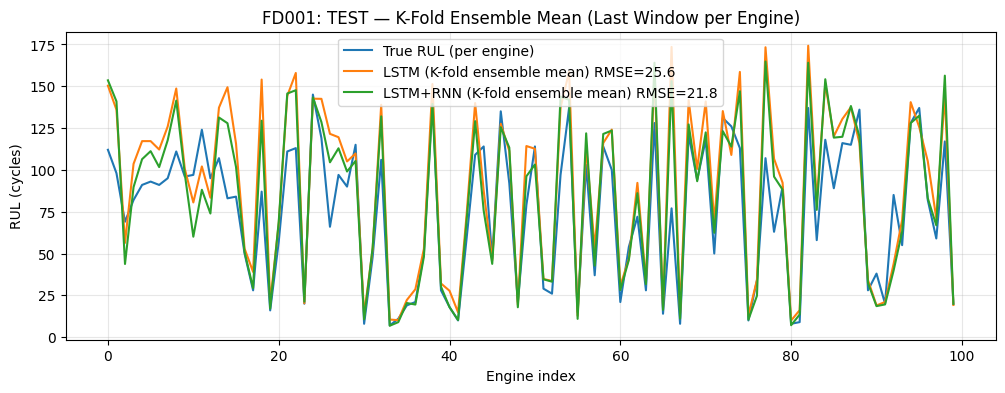


FD002 | GroupKFold (K=5) | LSTM vs LSTM+RNN + Ensemble Plot
FD002 | Fold 1/5 | Val RMSE: LSTM=37.71, LSTM+RNN=37.27 | Test RMSE: LSTM=29.61, LSTM+RNN=29.50
FD002 | Fold 2/5 | Val RMSE: LSTM=34.17, LSTM+RNN=34.08 | Test RMSE: LSTM=31.86, LSTM+RNN=29.16
FD002 | Fold 3/5 | Val RMSE: LSTM=36.70, LSTM+RNN=37.33 | Test RMSE: LSTM=30.32, LSTM+RNN=30.50
FD002 | Fold 4/5 | Val RMSE: LSTM=37.58, LSTM+RNN=36.38 | Test RMSE: LSTM=29.44, LSTM+RNN=28.57
FD002 | Fold 5/5 | Val RMSE: LSTM=41.12, LSTM+RNN=38.51 | Test RMSE: LSTM=33.73, LSTM+RNN=29.62


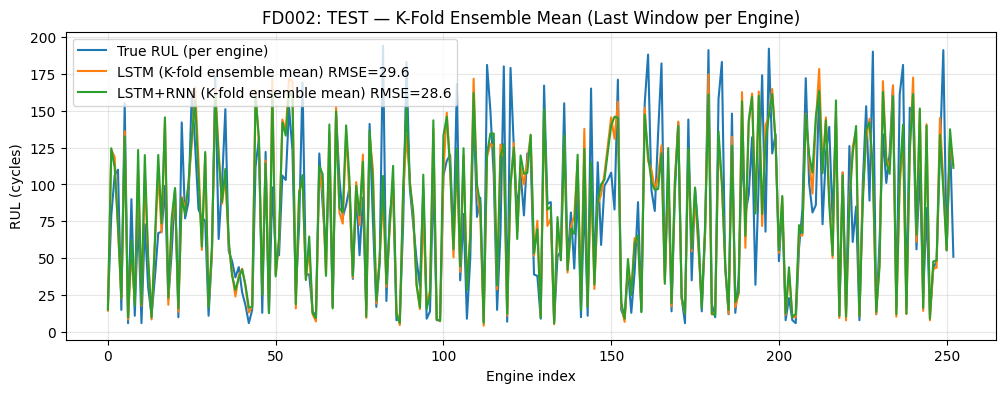


FD003 | GroupKFold (K=5) | LSTM vs LSTM+RNN + Ensemble Plot
FD003 | Fold 1/5 | Val RMSE: LSTM=57.42, LSTM+RNN=55.77 | Test RMSE: LSTM=37.49, LSTM+RNN=32.59
FD003 | Fold 2/5 | Val RMSE: LSTM=42.01, LSTM+RNN=41.50 | Test RMSE: LSTM=38.11, LSTM+RNN=42.78
FD003 | Fold 3/5 | Val RMSE: LSTM=49.14, LSTM+RNN=49.41 | Test RMSE: LSTM=33.57, LSTM+RNN=39.36
FD003 | Fold 4/5 | Val RMSE: LSTM=50.44, LSTM+RNN=51.62 | Test RMSE: LSTM=32.45, LSTM+RNN=35.07
FD003 | Fold 5/5 | Val RMSE: LSTM=51.16, LSTM+RNN=53.87 | Test RMSE: LSTM=43.25, LSTM+RNN=32.57


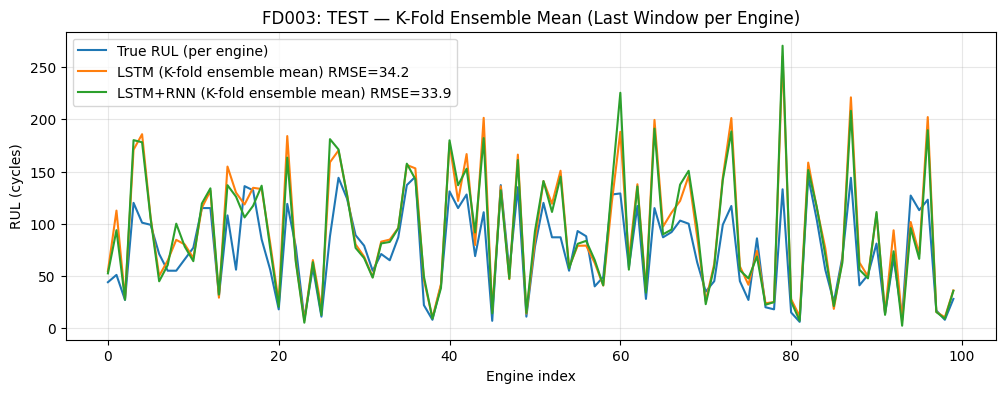


FD004 | GroupKFold (K=5) | LSTM vs LSTM+RNN + Ensemble Plot
FD004 | Fold 1/5 | Val RMSE: LSTM=58.61, LSTM+RNN=58.61 | Test RMSE: LSTM=35.42, LSTM+RNN=39.36
FD004 | Fold 2/5 | Val RMSE: LSTM=51.44, LSTM+RNN=50.41 | Test RMSE: LSTM=36.92, LSTM+RNN=38.55
FD004 | Fold 3/5 | Val RMSE: LSTM=53.00, LSTM+RNN=51.50 | Test RMSE: LSTM=38.70, LSTM+RNN=37.08
FD004 | Fold 4/5 | Val RMSE: LSTM=53.64, LSTM+RNN=52.71 | Test RMSE: LSTM=40.19, LSTM+RNN=34.53
FD004 | Fold 5/5 | Val RMSE: LSTM=50.62, LSTM+RNN=50.24 | Test RMSE: LSTM=36.38, LSTM+RNN=37.41


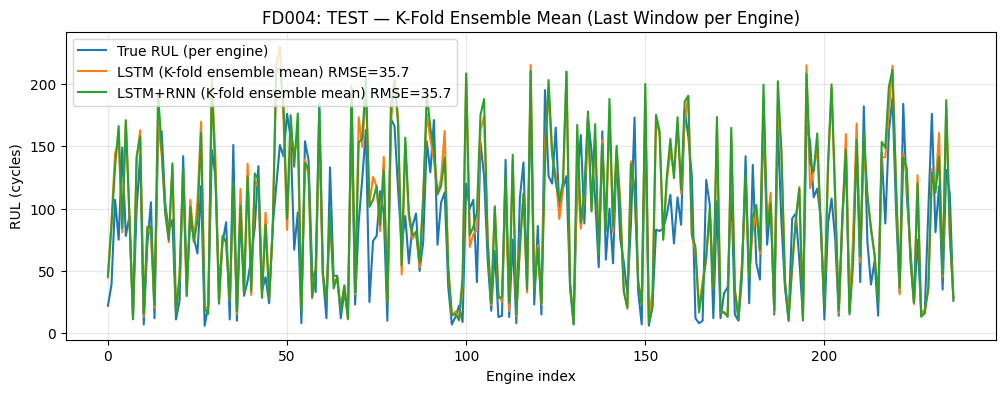


Per-fold results (sample):


FD  Fold     Model   Val_RMSE  Test_RMSE
0   FD001     1      LSTM  33.219026  32.158812
1   FD001     1  LSTM+RNN  37.058261  27.201278
2   FD001     2      LSTM  31.561752  30.099945
3   FD001     2  LSTM+RNN  31.573457  26.503065
4   FD001     3      LSTM  31.854690  23.193064
5   FD001     3  LSTM+RNN  31.611319  26.098151
6   FD001     4      LSTM  34.466519  28.134838
7   FD001     4  LSTM+RNN  32.992834  23.940533
8   FD001     5      LSTM  30.406235  24.988200
9   FD001     5  LSTM+RNN  31.612277  21.421489
10  FD002     1      LSTM  37.707792  29.612052
11  FD002     1  LSTM+RNN  37.269222  29.504678


K-Fold summary (mean ± std over folds):


FD     Model Val_RMSE_mean±std Test_RMSE_mean±std
0  FD001      LSTM      32.30 ± 1.57       27.71 ± 3.66
1  FD001  LSTM+RNN      32.97 ± 2.36       25.03 ± 2.36
2  FD002      LSTM      37.46 ± 2.49       30.99 ± 1.80
3  FD002  LSTM+RNN      36.71 ± 1.66       29.47 ± 0.70
4  FD003      LSTM      50.03 ± 5.50       36.97 ± 4.27
5  FD003  LSTM+RNN      50.43 ± 5.53       36.47 ± 4.48
6  FD004      LSTM      53.46 ± 3.12       37.52 ± 1.91
7  FD004  LSTM+RNN      52.69 ± 3.45       37.39 ± 1.84


TEST RMSE using ensemble-mean predictions across folds (one curve per model):


FD     Model  Test_RMSE_ensemble_mean
0  FD001      LSTM                25.575754
1  FD001  LSTM+RNN                21.799986
2  FD002      LSTM                29.621370
3  FD002  LSTM+RNN                28.608543
4  FD003      LSTM                34.214904
5  FD003  LSTM+RNN                33.906178
6  FD004      LSTM                35.744878
7  FD004  LSTM+RNN                35.708185

In [11]:
# =========================
# Group K-Fold Cross-Validation (by engine_id) + Final Plots (K-fold ensemble mean)
# Compare: (1) LSTM vs (2) LSTM + RNN for FD001..FD004
#
# What you get:
#   1) Per-fold VAL RMSE and TEST RMSE for both models
#   2) Mean ± std summary across folds
#   3) Final plots per FD using the AVERAGE (ensemble mean) of K fold TEST predictions
#
# Requires:
#   train_FD001..train_FD004, test_FD001..test_FD004, SENSOR_NAMES, and RUL already in both dataframes
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Reproducibility (PyTorch)
# -------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Config
# -------------------------
FDs = ["FD001", "FD002", "FD003", "FD004"]
K = 5  # GroupKFold splits

SEQ_LEN = 30
BATCH_SIZE = 256
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE = 8

# Model sizes (fair comparison)
LSTM_HIDDEN = 64
LSTM_LAYERS = 2
LSTM_DROPOUT = 0.25

RNN_HIDDEN = 32
RNN_LAYERS = 1
RNN_DROPOUT = 0.0

FEATURE_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"] + SENSOR_NAMES
TARGET_COL = "RUL"

# -------------------------
# Helpers
# -------------------------
def rmse_np(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))  # no squared=

def make_sequences(df_subset, X_scaled, y, seq_len=30, last_only=False):
    X_out, y_out = [], []
    df_subset = df_subset.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    start = 0
    for _, g in df_subset.groupby("engine_id", sort=True):
        n = len(g)
        Xi = X_scaled[start:start + n]
        yi = y[start:start + n]
        start += n

        if n < seq_len:
            continue

        if last_only:
            X_out.append(Xi[-seq_len:])
            y_out.append(yi[-1])
        else:
            for i in range(seq_len - 1, n):
                X_out.append(Xi[i - seq_len + 1:i + 1])
                y_out.append(yi[i])

    return np.asarray(X_out, dtype=np.float32), np.asarray(y_out, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def predict_numpy(model, X, batch_size=2048):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size]).to(device)
            yp = model(xb).detach().cpu().numpy().ravel()
            preds.append(yp)
    return np.concatenate(preds) if len(preds) else np.array([])

# -------------------------
# Models
# -------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, num_layers=2, dropout=0.25):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)

class LSTM_RNN_Regressor(nn.Module):
    """
    LSTM -> RNN -> Dense head
    """
    def __init__(self, n_features, lstm_hidden=64, lstm_layers=2, lstm_dropout=0.25,
                 rnn_hidden=32, rnn_layers=1, rnn_dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0.0,
        )
        self.rnn = nn.RNN(
            input_size=lstm_hidden,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            nonlinearity="tanh",
            batch_first=True,
            dropout=rnn_dropout if rnn_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(lstm_dropout),
            nn.Linear(rnn_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        z, _ = self.lstm(x)
        out, _ = self.rnn(z)
        last = out[:, -1, :]
        return self.head(last)

# -------------------------
# Training utilities
# -------------------------
def eval_rmse_loader(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yp = model(xb)
            preds.append(yp.detach().cpu().numpy().ravel())
            trues.append(yb.detach().cpu().numpy().ravel())
    preds = np.concatenate(preds) if len(preds) else np.array([])
    trues = np.concatenate(trues) if len(trues) else np.array([])
    return np.inf if len(preds) == 0 else rmse_np(trues, preds)

def train_model(model, train_loader, val_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    best_val = np.inf
    pat = 0
    best_state = None

    for _ in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            yp = model(xb)
            loss = criterion(yp, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

        val_rmse = eval_rmse_loader(model, val_loader)
        scheduler.step(val_rmse)

        if val_rmse < best_val:
            best_val = val_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            pat = 0
        else:
            pat += 1
            if pat >= PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, float(best_val)

# -------------------------
# Run GroupKFold + store fold TEST predictions (for ensemble plotting)
# -------------------------
fold_rows = []
ensemble_rows = []

for fd in FDs:
    print("\n" + "="*90)
    print(f"{fd} | GroupKFold (K={K}) | LSTM vs LSTM+RNN + Ensemble Plot")
    print("="*90)

    df_all = globals()[f"train_{fd}"].sort_values(["engine_id", "cycle"]).reset_index(drop=True)
    df_test = globals()[f"test_{fd}"].sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    groups = df_all["engine_id"].values
    gkf = GroupKFold(n_splits=K)

    # Store fold test predictions to compute ensemble mean
    test_preds_lstm = []
    test_preds_lstm_rnn = []
    y_true_last_ref = None

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(df_all, groups=groups), start=1):
        df_tr = df_all.iloc[tr_idx].copy()
        df_va = df_all.iloc[va_idx].copy()

        # ---- Scale (fit on train fold only)
        x_scaler = StandardScaler()
        X_tr_rows = x_scaler.fit_transform(df_tr[FEATURE_COLS].values)
        X_va_rows = x_scaler.transform(df_va[FEATURE_COLS].values)

        y_tr_rows = df_tr[TARGET_COL].values.astype(np.float32)
        y_va_rows = df_va[TARGET_COL].values.astype(np.float32)

        # ---- Sequences (train/val)
        Xtr, ytr = make_sequences(df_tr, X_tr_rows, y_tr_rows, seq_len=SEQ_LEN, last_only=False)
        Xva, yva = make_sequences(df_va, X_va_rows, y_va_rows, seq_len=SEQ_LEN, last_only=False)

        train_loader = DataLoader(SeqDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
        val_loader   = DataLoader(SeqDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        # ---- Build models
        lstm = LSTMRegressor(
            n_features=Xtr.shape[-1],
            hidden=LSTM_HIDDEN,
            num_layers=LSTM_LAYERS,
            dropout=LSTM_DROPOUT
        ).to(device)

        lstm_rnn = LSTM_RNN_Regressor(
            n_features=Xtr.shape[-1],
            lstm_hidden=LSTM_HIDDEN,
            lstm_layers=LSTM_LAYERS,
            lstm_dropout=LSTM_DROPOUT,
            rnn_hidden=RNN_HIDDEN,
            rnn_layers=RNN_LAYERS,
            rnn_dropout=RNN_DROPOUT
        ).to(device)

        # ---- Train (per fold)
        lstm, val_rmse_lstm = train_model(lstm, train_loader, val_loader)
        lstm_rnn, val_rmse_lstm_rnn = train_model(lstm_rnn, train_loader, val_loader)

        # ---- TEST (last window per engine) using THIS fold's scaler
        X_te_rows = x_scaler.transform(df_test[FEATURE_COLS].values)
        y_te_rows = df_test[TARGET_COL].values.astype(np.float32)
        X_last, y_true_last = make_sequences(df_test, X_te_rows, y_te_rows, seq_len=SEQ_LEN, last_only=True)

        if y_true_last_ref is None:
            y_true_last_ref = y_true_last
        else:
            # sanity check: same target vector ordering across folds
            if len(y_true_last_ref) != len(y_true_last):
                raise ValueError(f"{fd}: inconsistent test sequence count across folds.")

        y_pred_lstm = predict_numpy(lstm, X_last)
        y_pred_lstm_rnn = predict_numpy(lstm_rnn, X_last)

        test_rmse_lstm = rmse_np(y_true_last, y_pred_lstm)
        test_rmse_lstm_rnn = rmse_np(y_true_last, y_pred_lstm_rnn)

        test_preds_lstm.append(y_pred_lstm)
        test_preds_lstm_rnn.append(y_pred_lstm_rnn)

        fold_rows.append({"FD": fd, "Fold": fold, "Model": "LSTM",     "Val_RMSE": val_rmse_lstm,     "Test_RMSE": test_rmse_lstm})
        fold_rows.append({"FD": fd, "Fold": fold, "Model": "LSTM+RNN", "Val_RMSE": val_rmse_lstm_rnn, "Test_RMSE": test_rmse_lstm_rnn})

        print(f"{fd} | Fold {fold}/{K} | Val RMSE: LSTM={val_rmse_lstm:.2f}, LSTM+RNN={val_rmse_lstm_rnn:.2f} "
              f"| Test RMSE: LSTM={test_rmse_lstm:.2f}, LSTM+RNN={test_rmse_lstm_rnn:.2f}")

    # ---- Ensemble mean predictions across folds (one curve per model)
    P_lstm = np.vstack(test_preds_lstm)           # (K, n_engines)
    P_lstm_rnn = np.vstack(test_preds_lstm_rnn)   # (K, n_engines)

    y_pred_lstm_mean = P_lstm.mean(axis=0)
    y_pred_lstm_rnn_mean = P_lstm_rnn.mean(axis=0)

    rmse_lstm_ens = rmse_np(y_true_last_ref, y_pred_lstm_mean)
    rmse_lstm_rnn_ens = rmse_np(y_true_last_ref, y_pred_lstm_rnn_mean)

    ensemble_rows.append({"FD": fd, "Model": "LSTM",     "Test_RMSE_ensemble_mean": rmse_lstm_ens})
    ensemble_rows.append({"FD": fd, "Model": "LSTM+RNN", "Test_RMSE_ensemble_mean": rmse_lstm_rnn_ens})

    # ---- Final plot (ensemble mean)
    plt.figure(figsize=(12, 4))
    plt.plot(y_true_last_ref, label="True RUL (per engine)")
    plt.plot(y_pred_lstm_mean, label=f"LSTM (K-fold ensemble mean) RMSE={rmse_lstm_ens:.1f}")
    plt.plot(y_pred_lstm_rnn_mean, label=f"LSTM+RNN (K-fold ensemble mean) RMSE={rmse_lstm_rnn_ens:.1f}")
    plt.title(f"{fd}: TEST — K-Fold Ensemble Mean (Last Window per Engine)")
    plt.xlabel("Engine index")
    plt.ylabel("RUL (cycles)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# -------------------------
# Tables: Per-fold + mean ± std + ensemble mean RMSE
# -------------------------
df_folds = pd.DataFrame(fold_rows)
print("\nPer-fold results (sample):")
display(df_folds.head(12))

summary = (
    df_folds
    .groupby(["FD", "Model"])
    .agg(
        Val_RMSE_mean=("Val_RMSE", "mean"),
        Val_RMSE_std=("Val_RMSE", "std"),
        Test_RMSE_mean=("Test_RMSE", "mean"),
        Test_RMSE_std=("Test_RMSE", "std"),
    )
    .reset_index()
)

summary["Val_RMSE_mean±std"]  = summary["Val_RMSE_mean"].map(lambda x: f"{x:.2f}")  + " ± " + summary["Val_RMSE_std"].map(lambda x: f"{x:.2f}")
summary["Test_RMSE_mean±std"] = summary["Test_RMSE_mean"].map(lambda x: f"{x:.2f}") + " ± " + summary["Test_RMSE_std"].map(lambda x: f"{x:.2f}")

summary_display = summary[["FD", "Model", "Val_RMSE_mean±std", "Test_RMSE_mean±std"]].sort_values(["FD", "Model"])
print("\nK-Fold summary (mean ± std over folds):")
display(summary_display)

df_ensemble = pd.DataFrame(ensemble_rows).sort_values(["FD", "Model"])
print("\nTEST RMSE using ensemble-mean predictions across folds (one curve per model):")
display(df_ensemble)


## 🚀 Above & Beyond: Conservative and Deployment-Oriented RUL Prediction (LSTM+RNN)

In real maintenance applications, the most risky error is an **optimistic RUL estimate** (overestimating the remaining life), since it can delay inspection or intervention. For this reason, this block goes beyond training a single model and introduces a complete, **deployment-oriented** pipeline that improves **robustness**, **stability**, and **safety** of the final predictions.

### What this block does (FD001–FD004)
1) **Engine-wise GroupKFold (K = 5)**  
   Cross-validation is performed using `engine_id` as the group, ensuring no engine appears in both training and validation within a fold (no leakage).

2) **Multi-seed ensembling (SEEDS = [11, 22, 33])**  
   The full K-fold process is repeated for multiple random seeds, and predictions are averaged:
   - average across folds → **K-fold ensemble** (per seed)  
   - average across seeds → **multi-seed ensemble**  
   This reduces sensitivity to randomness and produces more reliable predictions.

3) **Three prediction outputs are generated and compared**
   - **Raw ensemble (unsmoothed):** the direct K-fold + multi-seed prediction (kept intentionally to show the true model output).  
   - **Smoothed prediction (Slew-Smooth / slope-limited smoothing):** replaces rolling mean/median with a **slew-rate limiter** that controls extreme point-to-point jumps while preserving the overall trend.  
     The smoothing strength is selected automatically from the raw curve using a quantile of `|diff|` (parameters: `SLEW_Q`, `SLEW_MIN_STEP`).  
   - **Conservative prediction:** the smoothed curve is shifted downward using a **validation-residual-based safety margin** (risk level `ALPHA = 0.05`).  
     If any conservative values become negative, a **conditional clip** is applied (minimum RUL = `CLIP_MIN = 1` cycle) to keep outputs physically meaningful.

### What is reported
For each FD subset, the code computes:
- **RMSE** for raw, smoothed, and conservative predictions  
- **Overestimation rate** (fraction of cases where predicted RUL > true RUL), to directly quantify model optimism  
- A summary table capturing margins, smoothing strength, and whether clipping was triggered

Overall, this block demonstrates the “above & beyond” contribution of the project: not only predicting RUL accurately, but also producing a **stable and conservative** output that is more suitable for real maintenance decision-making.


Device: cpu

FD001 | LSTM+RNN | GroupKFold(K=5) + Multi-Seed(3) + Slew-Smooth + Conservative + Conditional Clip


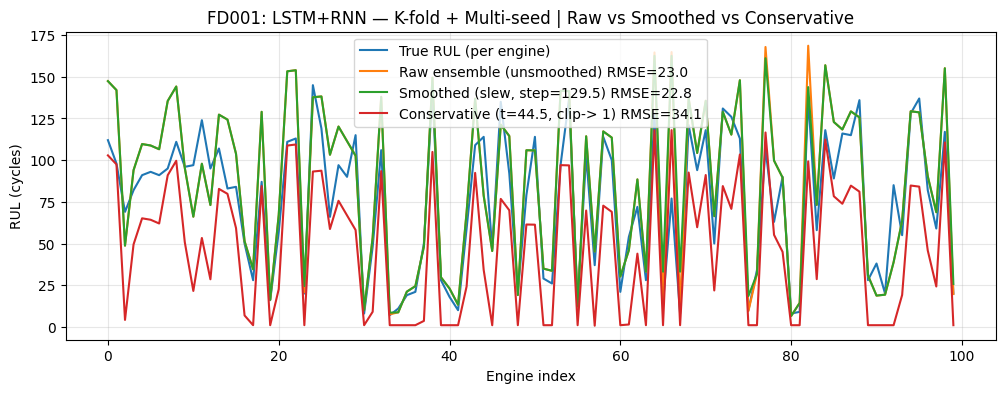


FD002 | LSTM+RNN | GroupKFold(K=5) + Multi-Seed(3) + Slew-Smooth + Conservative + Conditional Clip


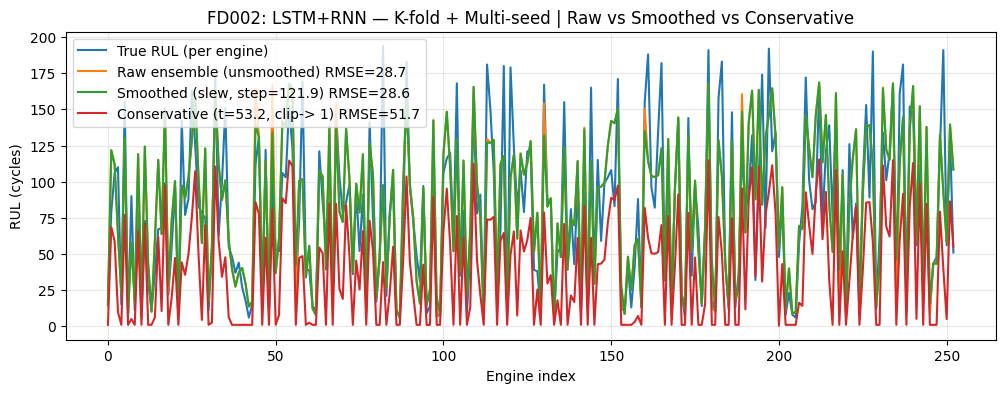


FD003 | LSTM+RNN | GroupKFold(K=5) + Multi-Seed(3) + Slew-Smooth + Conservative + Conditional Clip


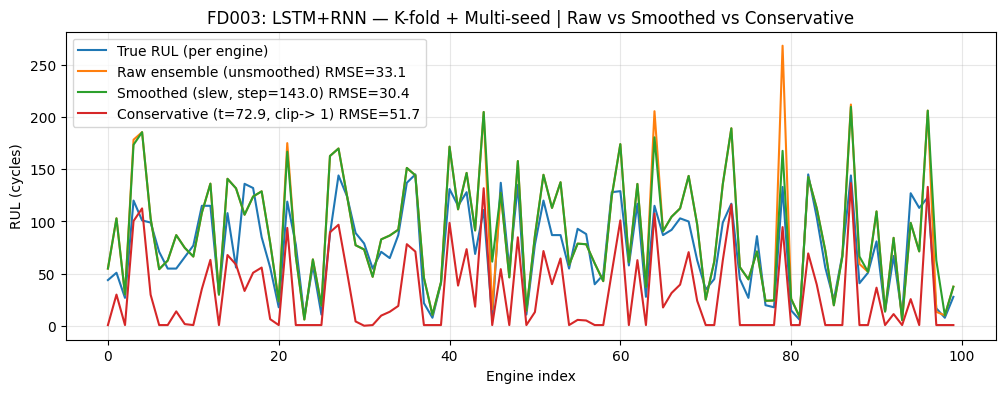


FD004 | LSTM+RNN | GroupKFold(K=5) + Multi-Seed(3) + Slew-Smooth + Conservative + Conditional Clip


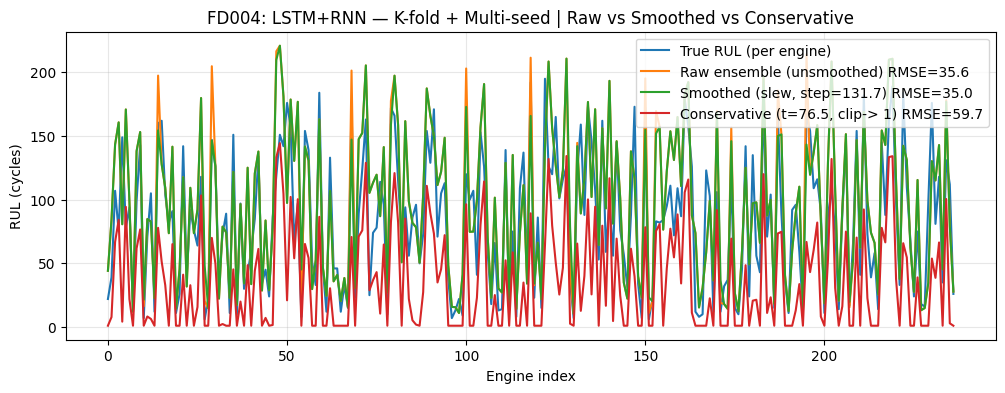

FD  K  n_seeds  ALPHA   t_margin  slew_q  slew_max_step   raw_RMSE  \
0  FD001  5        3   0.05  44.545658     0.9     129.458419  23.015709   
1  FD002  5        3   0.05  53.168346     0.9     121.890097  28.679934   
2  FD003  5        3   0.05  72.867859     0.9     143.013828  33.096426   
3  FD004  5        3   0.05  76.509140     0.9     131.706223  35.623527   

   smooth_RMSE  safe_RMSE  raw_over_rate  safe_over_rate  clipped_negatives  
0    22.762463  34.132251       0.720000        0.030000               True  
1    28.561450  51.745953       0.577075        0.031621               True  
2    30.373895  51.678113       0.720000        0.050000               True  
3    35.039731  59.747755       0.700422        0.042194               True

In [ ]:
# =========================
# LSTM+RNN ONLY (FD001–FD004): Multi-Seed + GroupKFold + (NEW) Slope-Limited Smoothing
# + Conservative Shift + Conditional Clip
#
# Changes vs your current version:
#   1) Replace rolling median/mean with a SLOPE-LIMITER (slew-rate) smoother:
#        - preserves spikes, but removes extreme sudden jumps (rate-of-change control)
#   2) Plot THREE predicted curves:
#        - Raw ensemble (UNSMOOTHED)  ✅ (as you requested)
#        - Smoothed curve (slope-limited)
#        - Conservative curve (smoothed - t, with conditional clip to 1 if <0)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# Global Config
# -------------------------
FDs = ["FD001", "FD002", "FD003", "FD004"]

K = 5
SEEDS = [11, 22, 33]  # add more seeds later if you want

SEQ_LEN = 30
BATCH_SIZE = 256
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE = 8

# LSTM+RNN sizes
LSTM_HIDDEN = 64
LSTM_LAYERS = 2
LSTM_DROPOUT = 0.25

RNN_HIDDEN = 32
RNN_LAYERS = 1
RNN_DROPOUT = 0.0

FEATURE_COLS = ["op_setting_1", "op_setting_2", "op_setting_3"] + SENSOR_NAMES
TARGET_COL = "RUL"

# Conservative controls
ALPHA = 0.05
CLIP_MIN = 1.0

# NEW smoothing: slope-limited (slew-rate) controls
# max_step is auto-chosen from the raw curve using a quantile of |diff|
SLEW_Q = 0.90          # higher => allows more spikes; lower => stronger smoothing
SLEW_MIN_STEP = 5.0    # prevents max_step from becoming too small

# -------------------------
# Reproducibility helper
# -------------------------
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Helpers: sequences + dataset + metrics
# -------------------------
def make_sequences(df_subset, X_scaled, y, seq_len=30, last_only=False):
    X_out, y_out = [], []
    df_subset = df_subset.sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    start = 0
    for _, g in df_subset.groupby("engine_id", sort=True):
        n = len(g)
        Xi = X_scaled[start:start + n]
        yi = y[start:start + n]
        start += n

        if n < seq_len:
            continue

        if last_only:
            X_out.append(Xi[-seq_len:])
            y_out.append(yi[-1])
        else:
            for i in range(seq_len - 1, n):
                X_out.append(Xi[i - seq_len + 1:i + 1])
                y_out.append(yi[i])

    return np.asarray(X_out, dtype=np.float32), np.asarray(y_out, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def rmse_np(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(np.asarray(y_true).ravel(), np.asarray(y_pred).ravel())))

def over_rate(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return float(np.mean(y_pred > y_true))

def predict_numpy(model, X, batch_size=2048):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size]).to(device)
            yp = model(xb).detach().cpu().numpy().ravel()
            preds.append(yp)
    return np.concatenate(preds) if len(preds) else np.array([])

# NEW smoothing: slope-limited / slew-rate limiter
def smooth_slew_rate(y, max_step):
    """
    Limits consecutive point changes:
      |y[i] - y[i-1]| <= max_step
    Preserves spikes, removes extreme sudden jumps (slope control).
    """
    y = np.asarray(y, dtype=float)
    out = y.copy()
    for i in range(1, len(out)):
        delta = out[i] - out[i-1]
        if delta > max_step:
            out[i] = out[i-1] + max_step
        elif delta < -max_step:
            out[i] = out[i-1] - max_step
    return out

def choose_max_step(y, q=0.90, min_step=5.0):
    y = np.asarray(y, dtype=float)
    if len(y) < 2:
        return float(min_step)
    diffs = np.abs(np.diff(y))
    step = float(np.quantile(diffs, q))
    return float(max(min_step, step))

# -------------------------
# Model: LSTM -> RNN -> head
# -------------------------
class LSTM_RNN_Regressor(nn.Module):
    def __init__(self, n_features,
                 lstm_hidden=64, lstm_layers=2, lstm_dropout=0.25,
                 rnn_hidden=32, rnn_layers=1, rnn_dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0.0,
        )
        self.rnn = nn.RNN(
            input_size=lstm_hidden,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            nonlinearity="tanh",
            batch_first=True,
            dropout=rnn_dropout if rnn_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Dropout(lstm_dropout),
            nn.Linear(rnn_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        z, _ = self.lstm(x)
        out, _ = self.rnn(z)
        last = out[:, -1, :]
        return self.head(last)

# -------------------------
# Training utilities
# -------------------------
def eval_rmse_loader(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yp = model(xb)
            preds.append(yp.detach().cpu().numpy().ravel())
            trues.append(yb.detach().cpu().numpy().ravel())
    preds = np.concatenate(preds) if len(preds) else np.array([])
    trues = np.concatenate(trues) if len(trues) else np.array([])
    return np.inf if len(preds) == 0 else rmse_np(trues, preds)

def train_model(model, train_loader, val_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    best_val = np.inf
    pat = 0
    best_state = None

    for _ in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            yp = model(xb)
            loss = criterion(yp, yb)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

        val_rmse = eval_rmse_loader(model, val_loader)
        scheduler.step(val_rmse)

        if val_rmse < best_val:
            best_val = val_rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            pat = 0
        else:
            pat += 1
            if pat >= PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return model, float(best_val)

# =========================
# Run
# =========================
final_summary_rows = []

for fd in FDs:
    print("\n" + "="*95)
    print(f"{fd} | LSTM+RNN | GroupKFold(K={K}) + Multi-Seed({len(SEEDS)}) + Slew-Smooth + Conservative + Conditional Clip")
    print("="*95)

    df_all = globals()[f"train_{fd}"].sort_values(["engine_id", "cycle"]).reset_index(drop=True)
    df_test = globals()[f"test_{fd}"].sort_values(["engine_id", "cycle"]).reset_index(drop=True)

    groups = df_all["engine_id"].values
    y_true_ref = None

    seed_ensembles_test = []
    all_val_residuals = []

    for seed in SEEDS:
        set_seed(seed)

        gkf = GroupKFold(n_splits=K)
        fold_test_preds = []
        fold_val_residuals = []

        for fold, (tr_idx, va_idx) in enumerate(gkf.split(df_all, groups=groups), start=1):
            df_tr = df_all.iloc[tr_idx].copy()
            df_va = df_all.iloc[va_idx].copy()

            # ---- Scale per fold (fit on train fold only)
            x_scaler = StandardScaler()
            X_tr_rows = x_scaler.fit_transform(df_tr[FEATURE_COLS].values)
            X_va_rows = x_scaler.transform(df_va[FEATURE_COLS].values)

            y_tr_rows = df_tr[TARGET_COL].values.astype(np.float32)
            y_va_rows = df_va[TARGET_COL].values.astype(np.float32)

            # ---- Build sequences (train/val)
            Xtr, ytr = make_sequences(df_tr, X_tr_rows, y_tr_rows, seq_len=SEQ_LEN, last_only=False)
            Xva, yva = make_sequences(df_va, X_va_rows, y_va_rows, seq_len=SEQ_LEN, last_only=False)

            train_loader = DataLoader(SeqDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
            val_loader   = DataLoader(SeqDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

            # ---- Train model
            model = LSTM_RNN_Regressor(
                n_features=Xtr.shape[-1],
                lstm_hidden=LSTM_HIDDEN,
                lstm_layers=LSTM_LAYERS,
                lstm_dropout=LSTM_DROPOUT,
                rnn_hidden=RNN_HIDDEN,
                rnn_layers=RNN_LAYERS,
                rnn_dropout=RNN_DROPOUT,
            ).to(device)

            model, _ = train_model(model, train_loader, val_loader)

            # ---- Validation residuals (raw): pred - true
            yva_pred = predict_numpy(model, Xva)
            fold_val_residuals.append(yva_pred - yva)

            # ---- Test last-window per engine (per-fold scaler)
            X_te_rows = x_scaler.transform(df_test[FEATURE_COLS].values)
            y_te_rows = df_test[TARGET_COL].values.astype(np.float32)

            X_last, y_true_last = make_sequences(df_test, X_te_rows, y_te_rows, seq_len=SEQ_LEN, last_only=True)

            if y_true_ref is None:
                y_true_ref = y_true_last
            else:
                if len(y_true_ref) != len(y_true_last):
                    raise ValueError(f"{fd}: inconsistent number of test sequences (check SEQ_LEN).")

            y_pred_last = predict_numpy(model, X_last)
            fold_test_preds.append(y_pred_last)

        # ---- K-fold ensemble for this seed
        y_pred_seed = np.vstack(fold_test_preds).mean(axis=0)
        seed_ensembles_test.append(y_pred_seed)

        # ---- Pool residuals
        all_val_residuals.append(np.concatenate(fold_val_residuals))

    # ---- Multi-seed ensemble mean (RAW, UNSMOOTHED)
    y_pred_raw = np.vstack(seed_ensembles_test).mean(axis=0)

    # ---- NEW smoothing: slope-limited smoothing applied to raw curve
    max_step = choose_max_step(y_pred_raw, q=SLEW_Q, min_step=SLEW_MIN_STEP)
    y_pred_smooth = smooth_slew_rate(y_pred_raw, max_step=max_step)

    # ---- Conservative margin from pooled validation residuals
    residuals_all = np.concatenate(all_val_residuals)
    t_raw = float(np.quantile(residuals_all, 1 - ALPHA))
    t = float(max(0.0, t_raw))

    # ---- Conservative curve (apply shift after smoothing)
    y_pred_safe = y_pred_smooth - t

    # ---- Conditional clip ONLY if any point goes below 0
    clipped = False
    if np.any(y_pred_safe < 0):
        y_pred_safe = np.where(y_pred_safe < 0, CLIP_MIN, y_pred_safe)
        clipped = True

    # ---- Metrics
    rmse_raw = rmse_np(y_true_ref, y_pred_raw)          # raw (UNSMOOTHED)
    rmse_smooth = rmse_np(y_true_ref, y_pred_smooth)    # smoothed
    rmse_safe = rmse_np(y_true_ref, y_pred_safe)        # conservative
    over_raw = over_rate(y_true_ref, y_pred_raw)
    over_safe = over_rate(y_true_ref, y_pred_safe)

    final_summary_rows.append({
        "FD": fd,
        "K": K,
        "n_seeds": len(SEEDS),
        "ALPHA": ALPHA,
        "t_margin": t,
        "slew_q": SLEW_Q,
        "slew_max_step": max_step,
        "raw_RMSE": rmse_raw,
        "smooth_RMSE": rmse_smooth,
        "safe_RMSE": rmse_safe,
        "raw_over_rate": over_raw,
        "safe_over_rate": over_safe,
        "clipped_negatives": clipped,
    })

    # ---- Plot: TRUE + RAW (unsmoothed) + SMOOTH + CONSERVATIVE
    plt.figure(figsize=(12, 4))
    plt.plot(y_true_ref, label="True RUL (per engine)")
    plt.plot(y_pred_raw, label=f"Raw ensemble (unsmoothed) RMSE={rmse_raw:.1f}")
    plt.plot(y_pred_smooth, label=f"Smoothed (slew, step={max_step:.1f}) RMSE={rmse_smooth:.1f}")
    clip_note = f", clip-> {CLIP_MIN:g}" if clipped else ""
    plt.plot(y_pred_safe, label=f"Conservative (t={t:.1f}{clip_note}) RMSE={rmse_safe:.1f}")
    plt.title(f"{fd}: LSTM+RNN — K-fold + Multi-seed | Raw vs Smoothed vs Conservative")
    plt.xlabel("Engine index")
    plt.ylabel("RUL (cycles)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# ---- Final summary table
df_final = pd.DataFrame(final_summary_rows)
display(df_final)
